<span style="font-size: 24pt; font-weight: bold;">Can yellow cards for football players be predicted?</span>



This notebook is part of my university project on predicting yellow cards for football players. I am using various libraries that provide tools and functions necessary for data analysis, visualization, optimization, and many other applications.

To fully utilize the capabilities, I import several libraries that are essential for my project. Here are some of them:

In [1407]:

from xgboost import XGBRegressor
import xgboost as xgb

from lightgbm import LGBMRegressor
import lightgbm as lgb

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures


from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping

Let's load the necessary player data and see what they contain.

In [1408]:
players = pd.read_csv('all_players_2021_2022.csv')

players.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3425 entries, 0 to 3424
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Player  3425 non-null   object 
 1   Pos     3425 non-null   int64  
 2   Age     3425 non-null   float64
 3   MP      3425 non-null   int64  
 4   Min     3425 non-null   float64
 5   90s     3425 non-null   float64
 6   Gls     3425 non-null   float64
 7   Ast     3425 non-null   float64
 8   CrdY    3425 non-null   float64
 9   CrdR    3425 non-null   float64
 10  xG      3425 non-null   float64
 11  Gls/90  3425 non-null   float64
 12  Ast/90  3425 non-null   float64
 13  xG/90   3425 non-null   float64
 14  2CrdY   3425 non-null   float64
 15  Fls     3425 non-null   float64
 16  Fld     3425 non-null   float64
 17  Off     3425 non-null   float64
 18  Crs     3425 non-null   float64
 19  Int     3425 non-null   float64
 20  TklW    3425 non-null   float64
 21  Recov   3425 non-null   float64
 22  

In [1409]:
players.head()

,Player,Pos,Age,MP,Min,90s,Gls,Ast,CrdY,CrdR,...,2CrdY,Fls,Fld,Off,Crs,Int,TklW,Recov,Won%,club
0,Thomas Müller,3,31.0,32,2558.0,28.4,8.0,18.0,0.0,0.0,...,0.0,11.0,22.0,12.0,89.0,15.0,20.0,94.0,35.6,bayern munich
1,Manuel Neuer,1,35.0,28,2510.0,27.9,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,85.0,71.4,bayern munich
2,Joshua Kimmich,3,26.0,28,2474.0,27.5,3.0,9.0,4.0,0.0,...,0.0,20.0,46.0,1.0,181.0,52.0,20.0,218.0,47.1,bayern munich
3,Dayot Upamecano,2,22.0,28,2211.0,24.6,1.0,6.0,4.0,0.0,...,0.0,28.0,11.0,1.0,2.0,32.0,42.0,249.0,59.0,bayern munich
4,Serge Gnabry,6,26.0,34,2185.0,24.3,14.0,5.0,0.0,0.0,...,0.0,11.0,21.0,15.0,79.0,14.0,31.0,146.0,20.6,bayern munich


As we can see, we have a lot of statistics regarding the players. 

These are players from the top 7 European leagues. Below are the data regarding the number of players in each position.

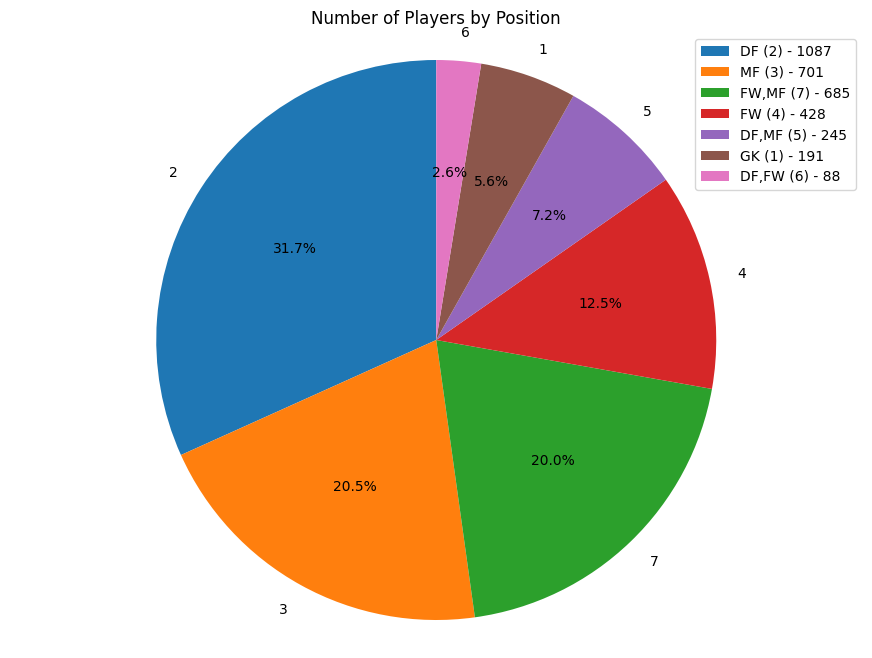

<Figure size 640x480 with 0 Axes>

In [1410]:
position_counts = players['Pos'].value_counts()

plt.figure(figsize=(11, 8))
patches, texts, autotexts = plt.pie(position_counts, labels=position_counts.index, autopct='%1.1f%%', startangle=90)

pos_mapping = {1 : 'GK (1)' , 2 :'DF (2)', 3 :'MF (3)', 4 : 'FW (4)', 5 : 'DF,MF (5)', 6 : 'DF,FW (6)', 7: 'FW,MF (7)'}

legend_labels = [f'{pos_mapping[pos]} - {position_counts[pos]}' for pos in position_counts.index]
plt.legend(patches, legend_labels, loc='upper right')

plt.title("Number of Players by Position")
plt.axis('equal')
plt.show()

plt.savefig('./diagrams/position_players.png')


Let's check which clubs have the most and least number of players. Here they are:

In [1411]:
club_counts = players['club'].value_counts()

club_with_most_players = club_counts.idxmax()
most_players_count = club_counts.max()

club_with_least_players = club_counts.idxmin()
least_players_count = club_counts.min()


print("The club with the most players:",
      club_with_most_players.capitalize(), f'({most_players_count})')
print("The club with the fewest players:",
      club_with_least_players.capitalize(), f'({least_players_count})')

The club with the most players: Genoa (32)
The club with the fewest players: Nec nijmegen (16)


Now let's move on to presenting statistics more relevant to the topic of my project. Below are the top 10 players with the highest number of yellow cards in the 2021/22 season.

In [1412]:
total_yellow_cards = players.groupby(['Player', 'Pos', 'club'])['CrdY'].sum()
total_yellow_cards = total_yellow_cards.sort_values(ascending=False)
top_10_table = pd.DataFrame(total_yellow_cards.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club', 'TotalYellowCards']

print("Top 10 players with the most yellow cards  in the 2021/22 season:")
top_10_table

Top 10 players with the most yellow cards  in the 2021/22 season:


,Player,Position,Club,TotalYellowCards
1,Gianluca Mancini,2,roma,16.0
2,Omar Alderete,2,valencia,15.0
3,Matt Crooks,3,middlesbrough,15.0
4,Maxime Lopez,3,sassuolo,14.0
5,Gustavo Hamer,3,coventry city,14.0
6,Sam Field,3,queens park rangers,14.0
7,Ethan Ampadu,5,venezia,13.0
8,Nathan Byrne,2,derby county,13.0
9,Jordan Ferri,3,montpellier,13.0
10,Geoffrey Kondogbia,5,atletico madrid,13.0


In [1413]:
players['CrdY/90'] = players['CrdY'] / players['90s']
yellow_cards_per_90 = players.groupby(['Player', 'Pos', 'club'])['CrdY/90'].mean()
yellow_cards_per_90 = yellow_cards_per_90.sort_values(ascending=False)
top_10_table = pd.DataFrame(yellow_cards_per_90.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club', 'YellowCardsPer90']

print("Top 10 players with the most yellow cards per 90 minutes in the 2021/22 season:")
top_10_table

Top 10 players with the most yellow cards per 90 minutes in the 2021/22 season:


,Player,Position,Club,YellowCardsPer90
1,Béni Makouana,7,montpellier,1.111111
2,Nikola Kalinić,4,hellas verona,1.111111
3,Aleksandar Sedlar,5,mallorca,1.111111
4,Kevin-Prince Boateng,7,hertha bsc,1.038961
5,David Tavares,3,famalicao,1.000000
6,Ilaix Moriba,3,valencia,0.989011
7,José Fontán,2,celta vigo,0.967742
8,Roberto Soldado,4,levante,0.945946
9,Tiago Araújo,6,arouca,0.943396
10,Kévin Malcuit,5,napoli,0.937500


Below are the top 10 players with the highest number of fouls in season 2021/2022.

In [1414]:
most_fouling_players = players.groupby(['Player', 'Pos', 'club'])['Fls'].sum()
most_fouling_players = most_fouling_players.sort_values(ascending=False)
top_10_table = pd.DataFrame(most_fouling_players.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club','TotalFouls']

print("Top 10 players with the most fouls committed in the 2021/22 season:")
top_10_table

Top 10 players with the most fouls committed in the 2021/22 season:


,Player,Position,Club,TotalFouls
1,Morten Thorsby,3,sampdoria,81.0
2,Enes Ünal,4,getafe,77.0
3,Otávio,7,porto,77.0
4,Elijah Adebayo,4,luton town,76.0
5,Brais Méndez,3,celta vigo,75.0
6,Sebastian Polter,4,bochum,75.0
7,Tommaso Pobega,3,torino,75.0
8,Dani de Wit,7,az alkmaar,72.0
9,Hugo Guillamón,5,valencia,71.0
10,Fran Navarro,4,gil vicente fc,70.0


In [1415]:
players['Fls/90'] = players['Fls'] / players['90s']
fouls_per_90 = players.groupby(['Player', 'Pos', 'club'])['Fls/90'].mean()
fouls_per_90 = fouls_per_90.sort_values(ascending=False)
top_10_table = pd.DataFrame(fouls_per_90.head(10))
top_10_table.reset_index(inplace=True)
top_10_table.index = range(1, len(top_10_table) + 1)
top_10_table.columns = ['Player', 'Position', 'Club' ,'FoulsPer90']

print("Top 10 players with the most fouls committed per 90 minutes in the 2021/22 season:")
top_10_table

Top 10 players with the most fouls committed per 90 minutes in the 2021/22 season:


,Player,Position,Club,FoulsPer90
1,Yan Brice Eteki,3,granada,4.736842
2,Tom Eaves,4,hull city,4.214286
3,Martin Adeline,7,reims,4.102564
4,Julio Romão,5,santa clara,4.000000
5,Monchu,3,granada,3.918919
6,Youssef Maleh,3,fiorentina,3.805310
7,Jean-Daniel Akpa-Akpro,3,lazio,3.714286
8,Safira,4,belenenses sad,3.664596
9,Diego Demme,3,napoli,3.636364
10,David Tavares,3,famalicao,3.600000


Below are statistics on the average number of yellow cards given by players, depending on their position:

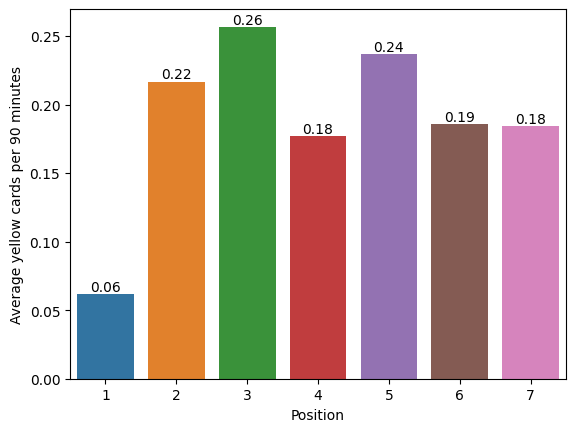

In [1416]:
def add_diagram_bar_values(precision=2):
    for i, bar in enumerate(plt.gca().patches):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(round(bar.get_height(), precision)),
                ha='center', va='bottom')



position_crdY = players.groupby(['Pos'])['CrdY/90'].mean().reset_index().sort_values(ascending=False, by='CrdY/90')
sns.barplot(x = 'Pos',y='CrdY/90',data=position_crdY)     
plt.xlabel('Position')
plt.ylabel('Average yellow cards per 90 minutes')

add_diagram_bar_values()

Here we present data on the relationship between 3 statistics: the number of minutes played by a player, the number of cards he has scored and fouls committed. 

As you can see, it's VERY dense here:

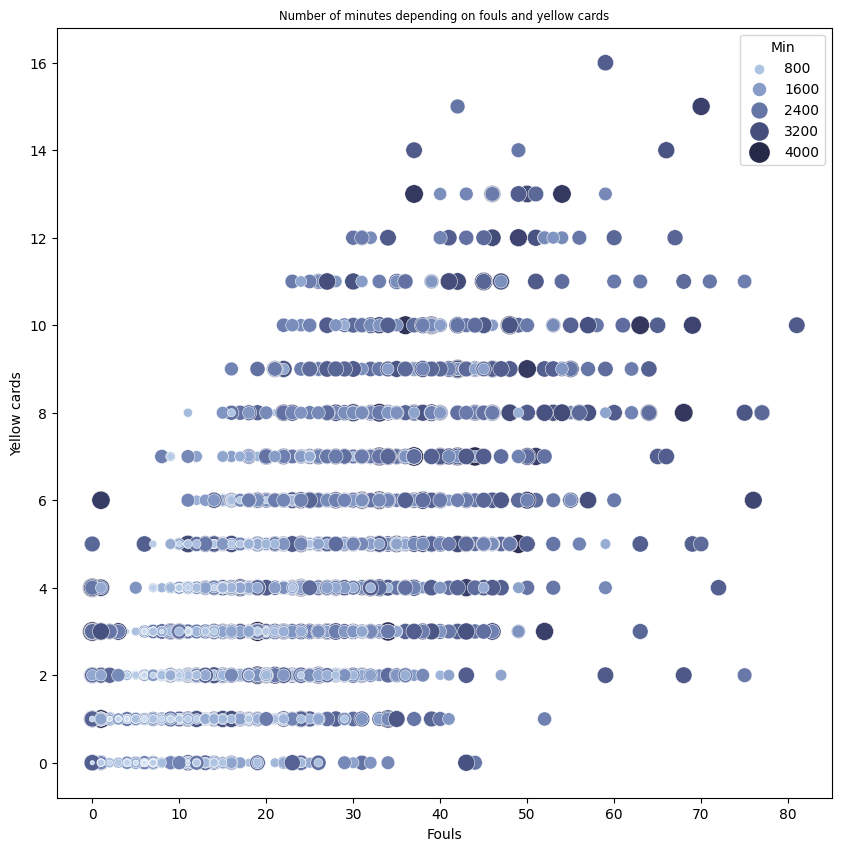

<Figure size 640x480 with 0 Axes>

In [1417]:
plt.figure(figsize=(10,10))
cmap = sns.cubehelix_palette(rot=-.1, as_cmap=True)
ax = sns.scatterplot(x="Fls", y="CrdY",  hue="Min", size ="Min",
                     palette=cmap, sizes=(10, 200), data=players)
plt.xlabel("Fouls")
plt.ylabel("Yellow cards")
ax.set_title('Number of minutes depending on fouls and yellow cards', {'fontsize': 'small'})
plt.show()

To facilitate the work and analysis of the data, a diagram showing the correlation between individual statistics of players has been generated below. The correlation values belong to the range <-1;1>. 

If the correlation value between two attributes is close to 1, then they are directly proportional to each other - if one value increases, so does the other. 

If the correlation value between two attributes is close to -1, then they are inversely proportional to each other - if one value increases, the other decreases and vice versa. 

And when it is 0, the attributes are totally independent of each other. 

C:\Users\trine\AppData\Local\Temp\ipykernel_18260\1590348859.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(players.corr(),linewidths=.5, annot=True );


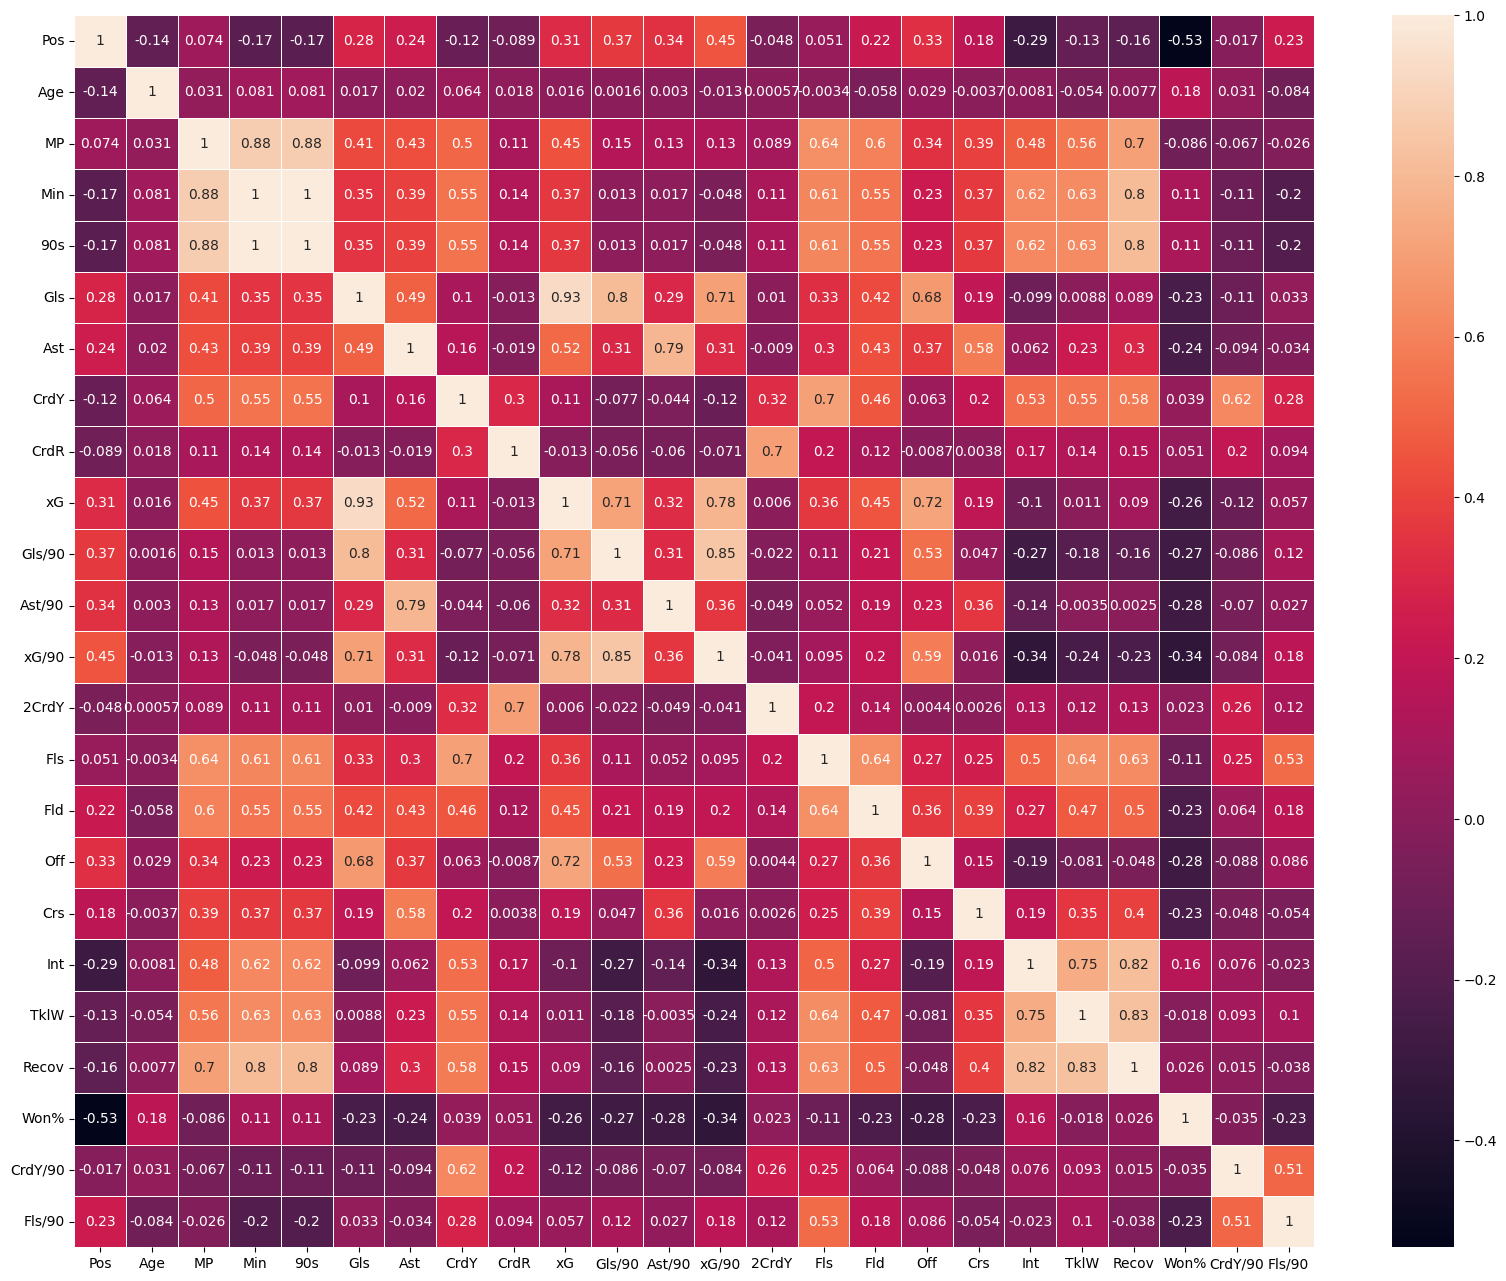

<Figure size 640x480 with 0 Axes>

In [1418]:
plt.figure(figsize=(20,16))
sns.heatmap(players.corr(),linewidths=.5, annot=True );
plt.yticks(rotation=360)
plt.show()

Now there are graphs showing the average number of yellow and red cards by age group of players in the 2021/22 season

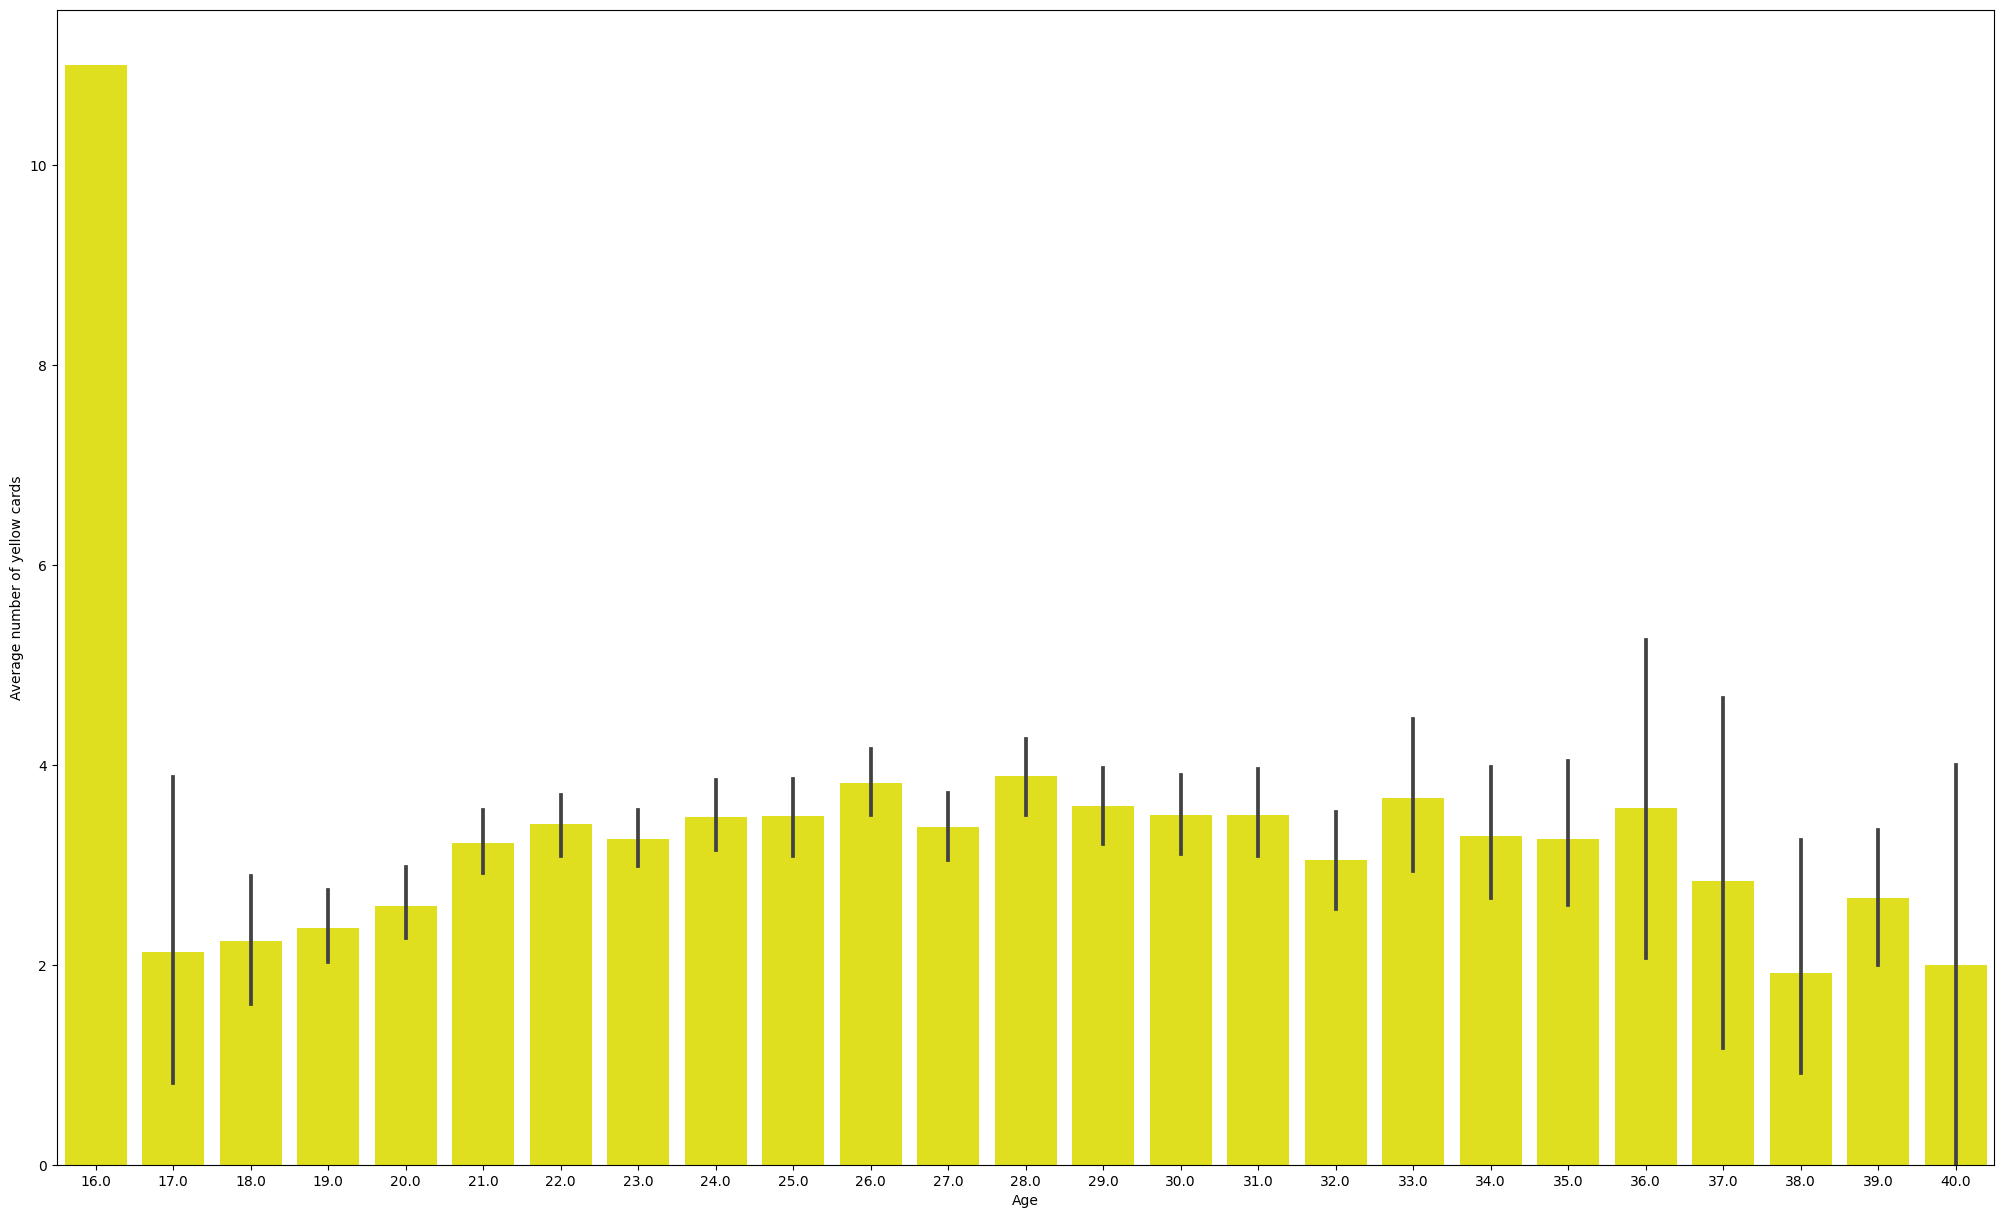

<Figure size 640x480 with 0 Axes>

In [1419]:
plt.figure(figsize=(25,15))
sns.barplot(x = 'Age',y='CrdY',data=players, color='yellow')
plt.xlabel('Age')
plt.ylabel('Average number of yellow cards')

plt.show()

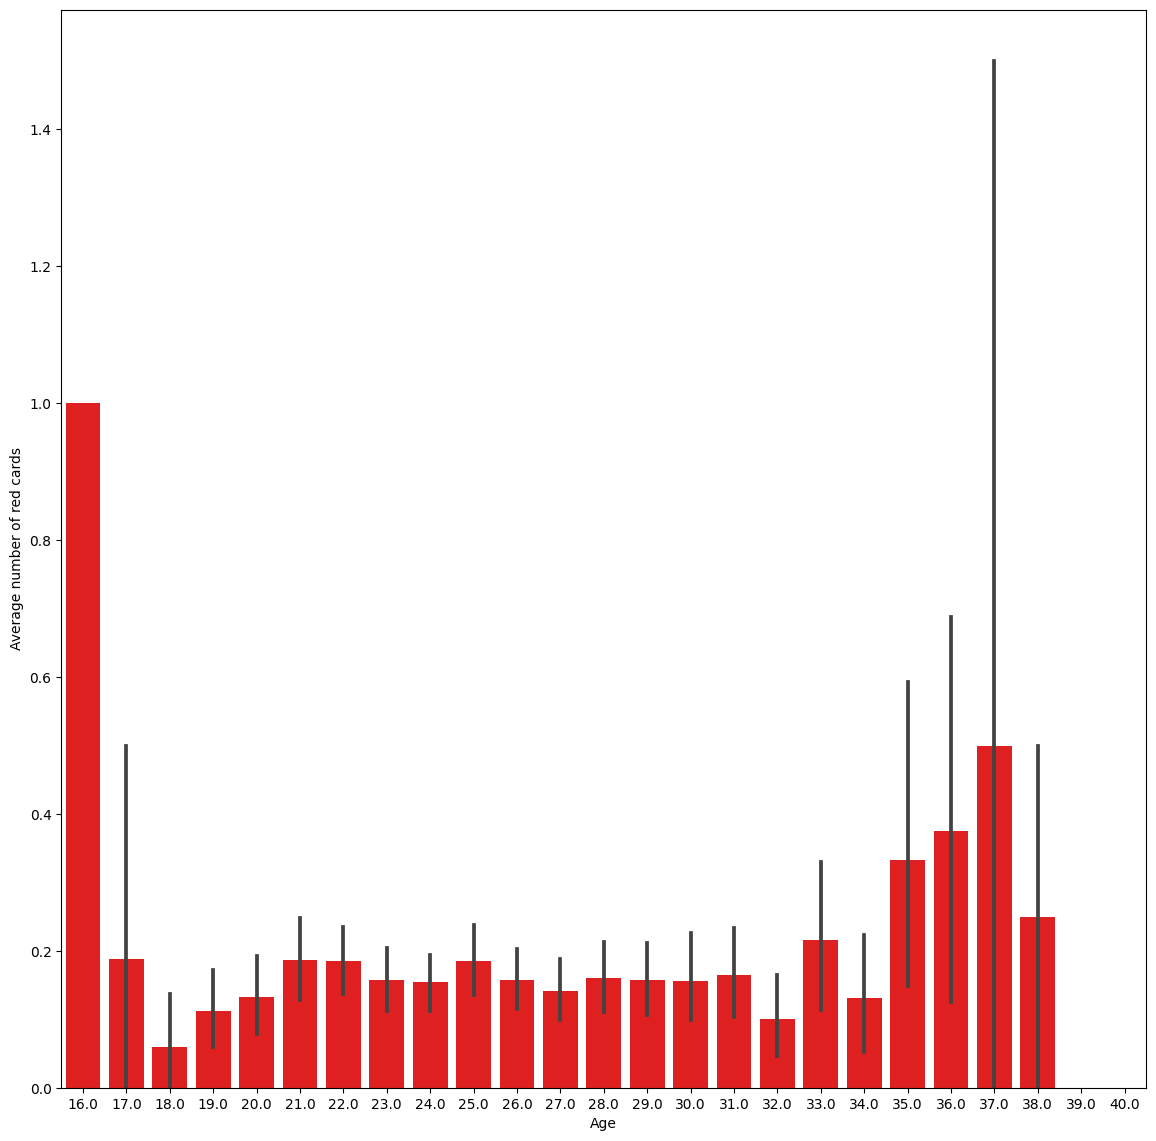

<Figure size 640x480 with 0 Axes>

In [1336]:
plt.figure(figsize=(14,14))
sns.barplot(x = 'Age',y='CrdR',data=players, color='red')
plt.xlabel('Age')
plt.ylabel('Average number of red cards')

plt.show()

To experiment a bit and find some dependencies, let's check that the number of matches played affects the number of yellow and red cards scored per 90 minutes by players in given positions.

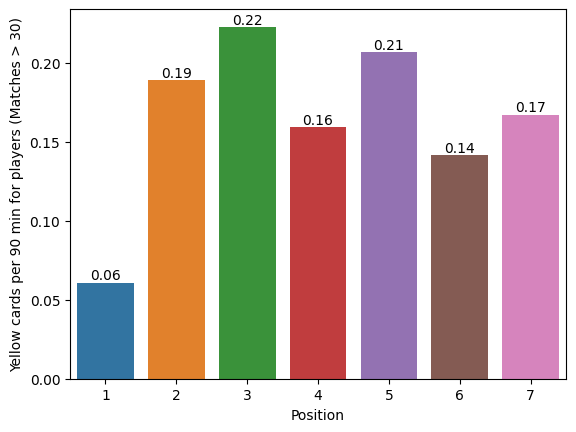

<Figure size 640x480 with 0 Axes>

In [1337]:
pos_crdY = players[players['MP']>30].groupby(['Pos'])['CrdY/90'].mean().reset_index()
pos_crdY = pos_crdY.sort_values(by='CrdY/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdY/90',data=pos_crdY)     
plt.xlabel('Position')
plt.ylabel('Yellow cards per 90 min for players (Matches > 30)')

add_diagram_bar_values()
plt.show()


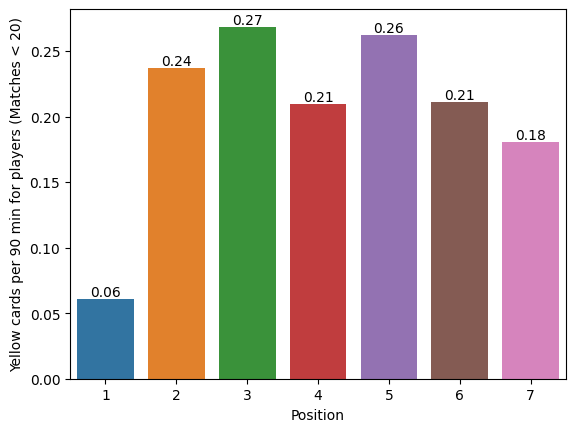

<Figure size 640x480 with 0 Axes>

In [1338]:
pos_crdY = players[players['MP']<20].groupby(['Pos'])['CrdY/90'].mean().reset_index()
pos_crdY = pos_crdY.sort_values(by='CrdY/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdY/90',data=pos_crdY)     
plt.xlabel('Position')
plt.ylabel('Yellow cards per 90 min for players (Matches < 20)')

add_diagram_bar_values()
plt.show()

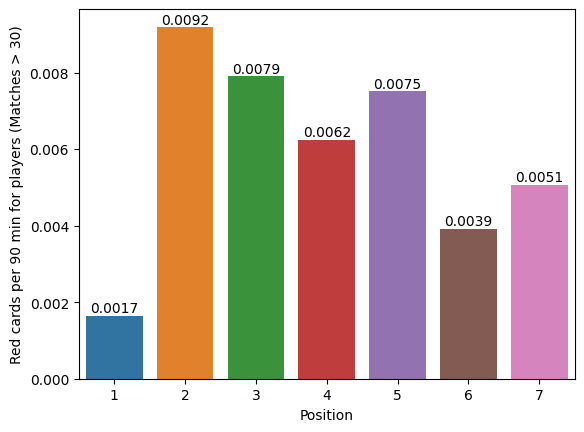

<Figure size 640x480 with 0 Axes>

In [1339]:
players['CrdR/90'] = players['CrdR'] / players['90s']
pos_crdR = players[players['MP']>30].groupby(['Pos'])['CrdR/90'].mean().reset_index()
pos_crdR = pos_crdR.sort_values(by='CrdR/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdR/90',data=pos_crdR)     
plt.xlabel('Position')
plt.ylabel('Red cards per 90 min for players (Matches > 30)')

add_diagram_bar_values(4)
plt.show()


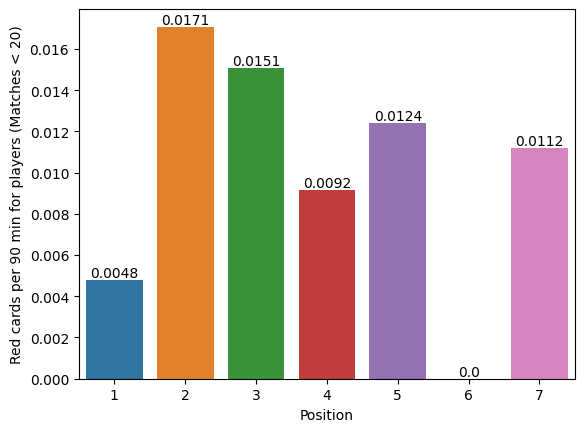

<Figure size 640x480 with 0 Axes>

In [1340]:
pos_crdR = players[players['MP']<20].groupby(['Pos'])['CrdR/90'].mean().reset_index()
pos_crdR = pos_crdR.sort_values(by='CrdR/90', ascending=False)
sns.barplot(x = 'Pos',y='CrdR/90',data=pos_crdR)     
plt.xlabel('Position')
plt.ylabel('Red cards per 90 min for players (Matches < 20)')

add_diagram_bar_values(4)
plt.show()

As you can see, players who have played fewer matches get yellow and red cards more often. Only goalkeepers receive the same number of yellow cards on average.


We are slowly moving on to the main calculations. Since we want to predict the number of yellow cards scored, regression is a better model for this. Let's check how the data on the cards highlighted in the list of attributes are presented. This list contains abbreviations of attribute names. Their full names are as follows:

+ Age - player's age
+ MP - number of matches played
+ Min - minutes played
+ 90s - number of 90 minutes played
+ Gls - number of goals scored
+ Ast - number of assists scored
+ xG - number of expected goals
+ Gls/90 - number of goals scored per 90 minutes
+ Ast/90 - number of assists scored per 90 minutes
+ xG/90 - number of expected goals per 90 minutes
+ Fls - number of fouls committed
+ Fld - number of fouls drawn
+ Fls/90 - number of fouls committed per 90 minutes
+ Off - number of offsides
+ Crs - number of crosses (medium- to-long-range pass from a wide area of the field towards the centre of the field near the opponent's goal)
+ Int - number of interceptions (the catching of a pass by a player on an opposing team)
+ TklW - number of tackles in which the tackler's team won possession of the ball
+ Recov - number of loose balls recovered
+ Won% - percentage of aerials won


In [1341]:
x_features = ['Age','MP','Min','90s','Gls','Ast','xG','Gls/90','Ast/90','xG/90','Fls','Fld', 'Fls/90','Off','Crs','Int','TklW','Recov','Won%'] 

X = players.reindex(columns=x_features)

y = players.loc[:,"CrdY"]

model = sm.OLS(y, X, data=players)
results = model.fit()
results.summary()


c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                   CrdY   R-squared (uncentered):                   0.820
Model:                            OLS   Adj. R-squared (uncentered):              0.819
Method:                 Least Squares   F-statistic:                              817.0
Date:                Sat, 10 Jun 2023   Prob (F-statistic):                        0.00
Time:                        13:00:17   Log-Likelihood:                         -6974.0
No. Observations:                3425   AIC:                                  1.399e+04
Df Residuals:                    3406   BIC:                                  1.410e+04
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0181      0.006      3.237      0.001       0.007       0.029
MP            -0.0241      0.008     -2.888      0.004      -0.040      -0.008
Min           -0.0074      0.013     -0.585      0.559      -0.032       0.017
90s            0.7373      1.140      0.647      0.518      -1.499       2.973
Gls            0.0154      0.043      0.358      0.720      -0.069       0.100
Ast            0.0315      0.038      0.838      0.402      -0.042       0.105
xG            -0.1435      0.051     -2.796      0.005      -0.244      -0.043
Gls/90        -0.0146      0.599     -0.024      0.981      -1.189       1.160
Ast/90        -0.6604      0.583     -1.133      0.257      -1.803       0.482
xG/90         -0.3697      0.719     -0.514      0.607      -1.779       1.040
Fls            0.1264      0.006     21.540      0.000       0.115       0.138
Fld            0.0100      0.003      3.294      0.001       0.004       0.016
Fls/90         0.0027      0.085      0.032      0.974      -0.164       0.169
Off           -0.0159      0.010     -1.581      0.114      -0.036       0.004
Crs        -5.535e-05      0.001     -0.051      0.959      -0.002       0.002
Int            0.0255      0.004      6.202      0.000       0.017       0.034
TklW          -0.0086      0.005     -1.676      0.094      -0.019       0.001
Recov         -0.0028      0.001     -1.886      0.059      -0.006       0.000
Won%          -0.0006      0.002     -0.303      0.762      -0.004       0.003
==============================================================================
Omnibus:                      222.698   Durbin-Watson:                   1.908
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              346.848
Skew:                           0.526   Prob(JB):                     4.82e-76
Kurtosis:                       4.151   Cond. No.                     6.31e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [1342]:
y = players.loc[:,"CrdY/90"]
model = sm.OLS(y, X, data=players)
results = model.fit()
results.summary()

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\base\model.py:130: ValueWarning: unknown kwargs ['data']
  warnings.warn(msg, ValueWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                CrdY/90   R-squared (uncentered):                   0.735
Model:                            OLS   Adj. R-squared (uncentered):              0.733
Method:                 Least Squares   F-statistic:                              497.0
Date:                Sat, 10 Jun 2023   Prob (F-statistic):                        0.00
Time:                        13:00:17   Log-Likelihood:                          2014.6
No. Observations:                3425   AIC:                                     -3991.
Df Residuals:                    3406   BIC:                                     -3875.
Df Model:                          19                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Age            0.0031      0.000      7.547      0.000       0.002       0.004
MP            -0.0008      0.001     -1.312      0.190      -0.002       0.000
Min           -0.0013      0.001     -1.390      0.165      -0.003       0.001
90s            0.1146      0.083      1.387      0.166      -0.047       0.277
Gls            0.0031      0.003      1.000      0.317      -0.003       0.009
Ast            0.0014      0.003      0.503      0.615      -0.004       0.007
xG            -0.0016      0.004     -0.441      0.659      -0.009       0.006
Gls/90        -0.0274      0.043     -0.630      0.529      -0.112       0.058
Ast/90        -0.0433      0.042     -1.024      0.306      -0.126       0.040
xG/90         -0.1367      0.052     -2.624      0.009      -0.239      -0.035
Fls           -0.0005      0.000     -1.264      0.206      -0.001       0.000
Fld            0.0007      0.000      2.963      0.003       0.000       0.001
Fls/90         0.1362      0.006     22.145      0.000       0.124       0.148
Off           -0.0014      0.001     -1.885      0.059      -0.003    5.52e-05
Crs        -2.629e-07   7.87e-05     -0.003      0.997      -0.000       0.000
Int            0.0012      0.000      3.898      0.000       0.001       0.002
TklW          -0.0002      0.000     -0.536      0.592      -0.001       0.001
Recov         -0.0001      0.000     -1.132      0.258      -0.000    8.92e-05
Won%        8.951e-05      0.000      0.624      0.533      -0.000       0.000
==============================================================================
Omnibus:                      500.473   Durbin-Watson:                   1.909
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1337.461
Skew:                           0.796   Prob(JB):                    3.75e-291
Kurtosis:                       5.615   Cond. No.                     6.31e+04
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[3] The condition number is large, 6.31e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now let's load specially prepared test data of players from another season.

Let's also check the amount and numerical ratio to the current training data.

In [1343]:
test_players = pd.read_csv('test_2022_2023.csv')
test_players['Age'] = test_players['Age'].str[:2].astype(int)
test_players['Fls/90'] = test_players['Fls']/test_players['90s']
print(players.shape)
print(test_players.shape)
print("{:.2f}".format(test_players.shape[0]/(test_players.shape[0]+players.shape[0])))


test_players.head()

(3425, 27)
(869, 25)
0.20


,Player,Pos,Age,MP,Min,90s,Gls,Ast,CrdY,CrdR,...,Fls,Fld,Off,Crs,Int,TklW,Recov,Won%,club,Fls/90
0,Rodri,3,26,36,2911.0,32.3,2.0,6.0,5.0,0.0,...,47,20,3,6,33,41,301.0,69.2,manchester city,1.455108
1,Erling Haaland,4,22,35,2769.0,30.8,36.0,8.0,5.0,0.0,...,31,24,8,12,3,2,37.0,50.0,manchester city,1.006494
2,Kevin De Bruyne,3,31,32,2417.0,26.9,7.0,16.0,1.0,0.0,...,20,29,5,226,9,12,97.0,50.0,manchester city,0.743494
3,İlkay Gündoğan,3,31,31,2353.0,26.1,8.0,4.0,0.0,0.0,...,23,25,6,30,20,18,155.0,61.3,manchester city,0.881226
4,Manuel Akanji,2,27,29,2287.0,25.4,0.0,1.0,2.0,0.0,...,24,12,0,6,16,25,136.0,40.4,manchester city,0.944882


As you can see, unfortunately, our initial data do not have any major dependencies. However, let's try to figure it out and find a model that will show us whether it is possible to unambiguously answer the question asked in our hypothesis

As our features used to predict yellow cards per 90 minutes, the following were selected:
+ Age - player's age
+ Fls/90 - number of fouls committed per 90 minutes
+ 90s - number of 90 minutes played
+ Gls/90 - number of goals scored per 90 minutes
+ TklW - number of tackles in which the tackler's team won possession of the ball
+ Int - number of interceptions (the catching of a pass by a player on an opposing team)

They were chosen because they seem to me, as a football fan, to have the greatest influence on the game and behavior of the players

Let's start with the simplest regression model which is LinearRegression.


`LinearRegression` is a machine learning algorithm used for solving regression problems. It assumes a linear relationship between the independent variables and the target variable. The goal of `LinearRegression` is to find the best-fit line that minimizes the sum of the squared differences between the actual and predicted values.

In Python, the `scikit-learn` library provides an easy-to-use implementation of `LinearRegression`. It allows you to train a linear regression model by fitting it to a dataset with known input-output pairs. Once trained, the model can be used to make predictions on new data.

First, let's find the best polynomial degree for both the training and test data.


In [1344]:
X_train, y_train = players[['Age', 'Fls/90' ,'90s', 'Gls/90', 'TklW', 'Int']], players[['CrdY/90']]


X_test, y_test = test_players[['Age', 'Fls/90' ,'90s', 'Gls/90', 'TklW', 'Int']], test_players['CrdY']/test_players['90s']


degrees = [2,3,4,5,6,7,8]
for degree in degrees:
    lr = LinearRegression()
    pol_feat = PolynomialFeatures(degree=degree, include_bias=False, interaction_only=False)

    model = lr.fit(pol_feat.fit_transform(X_train), y_train)

    print(f'R^2 for {degree} polynomial degree:')
    r_sqr = lr.score(pol_feat.fit_transform(X_train), y_train)
    print(f'Train r^2 = {r_sqr}')
    r_sqr = lr.score(pol_feat.fit_transform(X_test), y_test)
    print(f'Test r^2 = {r_sqr}')
    print('---------')



    


R^2 for 2 polynomial degree:
Train r^2 = 0.3066558083685973
Test r^2 = 0.33392387105053223
---------
R^2 for 3 polynomial degree:
Train r^2 = 0.3224737780596829
Test r^2 = 0.32762661903713364
---------
R^2 for 4 polynomial degree:
Train r^2 = 0.35217616494387294
Test r^2 = 0.31799786104795424
---------
R^2 for 5 polynomial degree:
Train r^2 = 0.4025056564697467
Test r^2 = 0.18438015819466747
---------
R^2 for 6 polynomial degree:
Train r^2 = 0.4491209927724539
Test r^2 = -18.178459528102454
---------
R^2 for 7 polynomial degree:
Train r^2 = 0.5809277033322346
Test r^2 = -513.9245590583089
---------
R^2 for 8 polynomial degree:
Train r^2 = 0.714423821363342
Test r^2 = -280060.5975608839
---------


As can be seen, the higher the degree of the polynomial, the better the fit to the training data. Unfortunately, the results for the test data suffer from this, as they deteriorate significantly as the degree of the polynomial increases.

Therefore, all my further calculations for my data will be done for the second degree of the polynomial to make the results as comparable and reliable as possible.

Due to the number of characteristics according to which we want to predict yellow cards, it is not possible to present our data on the chart.

Graphs for more than 2 variables are unfeasible and hard to imagine for the human mind.

Now let's retrain to a model for normal `LinearRegression`.

In [1345]:
lr = LinearRegression()

model1 = lr.fit(X_train, y_train)

model1.coef_

array([[ 0.00301918,  0.12637597, -0.00132616, -0.11237664, -0.00019764,
         0.00118643]])

Below is a comparison of what our prediction results look like compared to real data.

In [1346]:
def generate_a_comparison_of_prediction_and_reality(target, actual_data, predicted_data, type_of_data):

    plt.scatter(actual_data, predicted_data, alpha=0.5)
    plt.xlabel(f'Actual number of {target}')
    plt.ylabel(f'Expected number of {target}')
    plt.title(f'Scatterplot: Actual vs. Expected {target} ({type_of_data} data)')

    line = np.linspace(min(actual_data), max(actual_data), 100)
    plt.plot(line, line, color='red', linestyle='--', linewidth=2, label='Line matching')

    plt.legend()
    plt.show()  

# generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', predictions_df['CrdY/90'], predictions_df['lr_p_CrdY/90'], 'train')
# generate_a_comparison_of_prediction_and_reality('yellow cards per 90 minutes', test_predictions_df['CrdY/90'], test_predictions_df['lr_p_CrdY/90'], 'test')

Now we move on to the next regression model - `XGBRegressor` from the xgboost library.

XGBRegressor`` is a gradient boosting algorithm specifically designed for regression tasks. It utilizes an ensemble of decision trees to make predictions on continuous targets. It excels at handling complex relationships, capturing interactions between variables, and handling noisy or correlated features. With tunable hyperparameters, such as learning rate, number of trees, and tree depth, it achieves a balance between model complexity and generalization ability. `XGBRegressor` also provides feature importance scores. 

Overall, it is a powerful algorithm widely used in regression tasks due to its strong predictive performance and flexibility.


In [1347]:
xgbr = XGBRegressor()

model2 = xgbr.fit(X_train, y_train)

Next, we will explore another regression model - `LGBMRegressor` from lightgbm library

`LGBMRegressor` is a part of the LightGBM library and is used for regression tasks using the gradient boosting method. It is a specifically designed regression algorithm based on decision trees that offers scalability, efficiency, and good predictive performance.

`LGBMRegressor` is used for training regression models where the goal is to predict numerical values based on a set of features. It operates on a similar principle to other gradient boosting models, where it iteratively adds decision trees to the model to correct the errors made by previous trees.

In [1348]:
lgbm = LGBMRegressor()

model3 = lgbm.fit(X_train, y_train)


This time we will train our `LGBMRegressor` model with the given parameters.

Each of them plays a role in training the model, and here is an overview of these parameters:

`objective='regression'` - parameter specifying the regression goal.

`n_estimators=750` - the number of decision trees (estimators) to build. A higher value will result in a more complex model, but it may also lead to longer training time.

`max_depth=4` - the maximum depth of each tree in the model. It controls the model's complexity by limiting the number of nodes in the tree. Higher values can lead to more complex models but may also increase the risk of overfitting.

`learning_rate=0.05` - the learning rate, which controls how quickly the model adapts to the data. A lower value means the model learns slower but may lead to better generalization.

`min_child_samples=1` - the minimum number of samples required to create a new node in the tree. Higher values can simplify the model and reduce the risk of overfitting.

`colsample_bytree=0.9` - random feature (column) subsampling for each tree. It determines the percentage of features that will be considered when building each tree. Higher values can result in greater tree diversity and better generalization.

`subsample=0.9` - random subsampling of samples (rows) for each tree. It determines the percentage of samples that will be considered when building each tree. Higher values can result in greater tree diversity and better generalization.

`random_state=101` - setting the seed for the random number generator to ensure result reproducibility.

In [1349]:
lgbm = LGBMRegressor(objective='regression', 
                    n_estimators=750, 
                    max_depth=4, 
                    learning_rate=0.05, 
                    min_child_samples=1,
                    colsample_bytree=0.9,
                    subsample=0.9,
                    random_state=101)

model4 = lgbm.fit(X_train, y_train)

The next way to predict yellow cards will be neural networks.

A neural network for regression models predicts continuous numerical values. It consists of interconnected neurons that process input data through hidden layers, producing an output value. During training, weights are adjusted based on prediction errors using backpropagation and gradient descent. The network's architecture, activation functions, and hyperparameters affect its capacity and learning ability. Once trained, it predicts outputs for new data. Neural networks excel at capturing complex patterns, but proper design, training, and validation are essential for optimal performance and generalization.

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


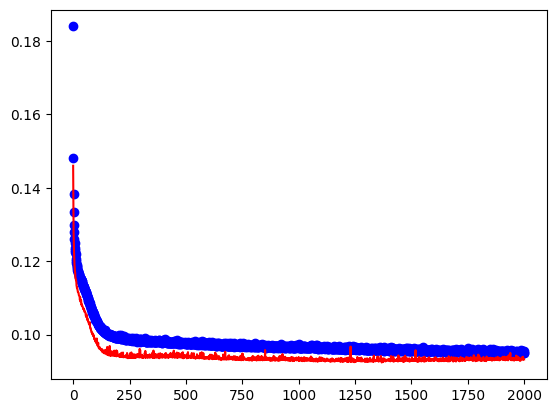

In [1350]:
def make_neural_network(X_train, y_train, X_test, y_test, earlystopper=None):
    model = Sequential()
    model.add(Dense(13, input_shape=(len(X_train.columns),), activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(13, activation='relu'))
    model.add(Dense(1,))
    model.compile(Adam(lr=0.0001), 'mean_absolute_error')

    if earlystopper != None:
        model_hist = model.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), verbose = 0, callbacks=[earlystopper])
    else:
        model_hist = model.fit(X_train, y_train, epochs = 2000, validation_split = 0, validation_data=(X_test, y_test), verbose = 0)

    model_dict = model_hist.history
    loss_values = model_dict['loss']
    val_loss_values = model_dict['val_loss']
    plt.plot(loss_values,'bo',label='training loss')
    plt.plot(val_loss_values,'r',label='training loss val')

    return model

model5 = make_neural_network(X_train, y_train, X_test, y_test)



The diagram above shows how the error of our model decreased over the epochs.

In neural networks, epochs refer to the number of times the entire training dataset is passed through the network during the training process. It is an important concept in training neural networks.

During each epoch, the network receives the training data, makes predictions, calculates the loss (error) between the predicted output and the actual target values, and adjusts the weights using an optimization algorithm such as gradient descent. The goal is to iteratively improve the network's performance by reducing the loss.

Now let's create a neural network model similar to the previous one, this time with a stop condition in the event that after a certain number of epochs, there is no improvement of the validation error, in our case after 50 epochs ( `patience=50` )

Validation loss is a measure that evaluates how well a model generalizes on validation data, which is not used during training. In the context of neural networks, the validation loss measures the difference between the model's predictions and the actual values on the validation data.

During training, the model is adjusted to the training data to minimize the loss. However, if the model becomes too overfit, it may poorly generalize to new, unseen data. To assess the model's ability to generalize, a validation set is used, which contains data not present in the training set.

In this model of neural networks, the `EarlyStopping` object appears, which is responsible for stopping the training of the neural network. The individual parameters that are passed to the constructor of the `EarlyStopping` class are explained below:

+ `monitor='val_loss'`: The monitor parameter specifies the metric to monitor the training progress. In this case, the monitored metric is val_loss, which represents the loss value on the validation set. The model will be observed to minimize this metric.

+ `min_delta=0`: The min_delta parameter determines the minimum change required in the monitored metric to be considered as an improvement. A value of 0 means that we expect no decrease in the monitored metric.

+ `patience=50`: The patience parameter specifies the number of epochs to continue training even if the monitored metric doesn't improve. If there is no improvement for patience consecutive epochs, the training will be stopped.

+ `verbose=1`: The verbose parameter controls the verbosity level of the output messages during training. A value of 1 indicates that informative messages will be displayed when the training is stopped based on the defined conditions.

+ `mode='min'`: The mode parameter specifies whether to minimize the monitored metric (`'min'`) or maximize it (`'max'`). In this case, the value 'min' indicates that we aim to minimize the `'val_loss'`

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 267: early stopping


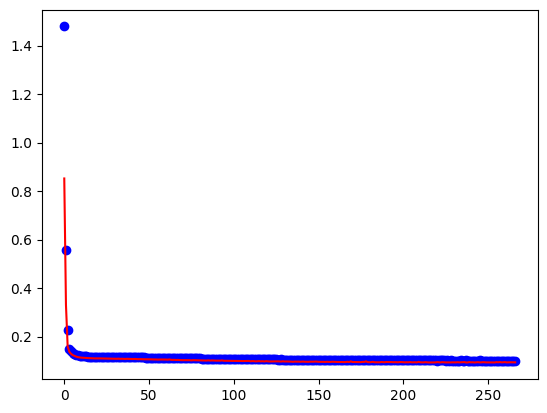

In [1351]:
earlystopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=50, verbose=1, mode='min')

model6 = make_neural_network(X_train, y_train, X_test, y_test, earlystopper)

The diagram above shows how the error of our model decreased over the epochs.

The last model we will use to build our regression model will be `DecisionTreeRegressor`.

`The DecisionTreeRegressor` builds a binary decision tree by recursively splitting the data based on feature thresholds. The splits are determined by minimizing chosen criterion, aiming to minimize the variance within each resulting partition.

During training, `the DecisionTreeRegressor` learns the optimal splits based on the provided input features and target values. It considers different features and thresholds to find the best split. The training process continues until certain stopping criteria, such as reaching a maximum depth or minimum number of samples in a leaf node, are met.

`The DecisionTreeRegressor` offers various parameters to control its behavior, such as the maximum depth of the tree, the minimum number of samples required to split a node, and the criterion used for splitting (e.g., MSE or MAE). These parameters allow for customization and trade-offs between model complexity and overfitting.

To begin with, let's choose a default model for our training data

In [1352]:
dtr1 = DecisionTreeRegressor()
model7 = dtr1.fit(X_train, y_train)

This time, we will pass parameters to our tree that will affect the training of our `DecisionTreeRegressor` model.

The parameter grid contains different values for the splitting criterion ('criterion'), the splitting strategy ( `splitter` ), the maximum depth of the tree ( `max_depth` ), the minimum number of samples required to split a node ( `min_samples_split` ), and the minimum impurity decrease required for splitting ( `min_impurity_decrease` ).

The `GridSearchCV` object is created, which performs the grid search. It is passed:
`DecisionTreeRegressor()` as the base model, `param_grid` as the parameter dictionary to be tested, `cv=5` indicating 5-fold cross-validation, which splits the training data into 5 subsets for model evaluation and `scoring='neg_mean_squared_error'` indicating that the evaluation metric is the negative mean squared error.

As a result, the code performs a grid search to find the optimal parameters for the `DecisionTreeRegressor` model and reports the best score (negative MSE) and best parameters discovered during this process.

At this point, it should be noted that I have made earlier attempts at the selection of parameters and the values below are the final version of these best attempts to match them.

In [1353]:
param_grid = {
    'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],
    'splitter' : ['random', 'best'],
    'max_depth' : [70, 80, 90, 100],
    'min_samples_split' : [50, 55, 60, 65, 70, 75],
    'min_impurity_decrease' : [0.0025, 0.005, 0.01]
}

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(X_train, y_train)
print('The best score: ', gridSearch.best_score_)
print('The best parameters: ', gridSearch.best_params_)

The best score:  -0.019307305037384117
The best parameters:  {'criterion': 'friedman_mse', 'max_depth': 90, 'min_impurity_decrease': 0.005, 'min_samples_split': 75, 'splitter': 'random'}


Below we take the best parameter for our `DecisionTreeRegressor` model and train it on our training data.

In [1354]:
# best_params = {'criterion': 'friedman_mse', 'max_depth': 80, 'min_impurity_decrease': 0.005, 'min_samples_split': 60, 'splitter': 'random'}
dtr2 = DecisionTreeRegressor(**gridSearch.best_params_)
model8 = dtr2.fit(X_train, y_train)

Now let's create sets that will hold information about the attributes on the basis of which we train and test models and predicted yellow cards for each model.

In [1355]:
train_predictions_df = pd.DataFrame({
    'Player': players['Player'],
    'Age': players['Age'],
    'Fls/90': players['Fls/90'],
    '90s': players['90s'],
    'Gls/90': players['Gls/90'],
    'TklW': players['TklW'],
    'Int': players['Int'],
    'CrdY/90': players['CrdY/90'],
})

test_predictions_df = pd.DataFrame({
    'Player': test_players['Player'],
    'Age': test_players['Age'],
    'Fls/90': test_players['Fls']/test_players['90s'],
    '90s': test_players['90s'],
    'Gls/90': test_players['Gls/90'],
    'TklW': test_players['TklW'],
    'Int': test_players['Int'],
    'CrdY/90': test_players['CrdY']/test_players['90s']
})

Now let's present our results so far in a compact form. Below are statistics comparing r², `MAE`, `MSE` for each model and the type of data that was used to generate them.

In [1356]:

NAMES_OF_PREDICTIONS_COLUMNS = ['lr_p_CrdY/90', 'xgbr_p_CrdY/90', 'lgbm1_p_CrdY/90', 'lgbm2_p_CrdY/90', 'krs1_p_CrdY/90','krs2_p_CrdY/90', 'dtr1_p_CrdY/90', 'dtr2_p_CrdY/90']

models = [model1, model2, model3, model4, model5, model6, model7, model8]

models_names = ['LinearRegression', 'XGBRegressor', 'LGBMRegressor 1','LGBMRegressor 2', 'NN Keras 1', 'NN Keras 2',  'DTRegressor 1', 'DTRegressor 2']



def predict_and_print_statistics(models, models_names, models_shortcuts, X_train, y_train, X_test, y_test, train_predictions_df, test_predictions_df):
    print('------------------------')
    for model, shortcut, name in zip(models, models_shortcuts, models_names):
        print(f'Statistics for {name}')

        train_predictions_df[shortcut] = model.predict(X_train).flatten()

        print(f'Train r²: {r2_score(y_train, train_predictions_df[shortcut])}')
        print(f'Train MAE: {mean_absolute_error(y_train, train_predictions_df[shortcut])}')
        print(f'Train MSE: {mean_squared_error(y_train, train_predictions_df[shortcut])}')

        test_predictions_df[shortcut] = model.predict(X_test).flatten()

        print(f'Test r²: {r2_score(y_test, test_predictions_df[shortcut])}')
        print(f'Test MAE: {mean_absolute_error(y_test, test_predictions_df[shortcut])}')
        print(f'Test MSE: {mean_squared_error(y_test, test_predictions_df[shortcut])}')

        print('------------------------')

    return train_predictions_df, test_predictions_df

train_predictions_df, test_predictions_df = predict_and_print_statistics(models, models_names, NAMES_OF_PREDICTIONS_COLUMNS, X_train,y_train, X_test, y_test, train_predictions_df, test_predictions_df)



------------------------
Statistics for LinearRegression
Train r²: 0.29129920466359804
Train MAE: 0.10077220919690684
Train MSE: 0.018344081722215515
Test r²: 0.32253508926312324
Test MAE: 0.09300058123398215
Test MSE: 0.015243783675128872
------------------------
Statistics for XGBRegressor
Train r²: 0.8823666541975347
Train MAE: 0.04052535725932352
Train MSE: 0.0030448331973915357
Test r²: 0.22403265466654465
Test MAE: 0.09968013344397884
Test MSE: 0.017460208143269283
------------------------
Statistics for LGBMRegressor 1
Train r²: 0.6372502298437848
Train MAE: 0.07475192457795207
Train MSE: 0.009389451052191747
Test r²: 0.2742498269649689
Test MAE: 0.09503036352594846
Test MSE: 0.016330260747969914
------------------------
Statistics for LGBMRegressor 2
Train r²: 0.7103742750702713
Train MAE: 0.06582853230490428
Train MSE: 0.007496701008279452
Test r²: 0.2602760024244247
Test MAE: 0.09650214909897875
Test MSE: 0.016644688779642536
------------------------
Statistics for NN Keras 1

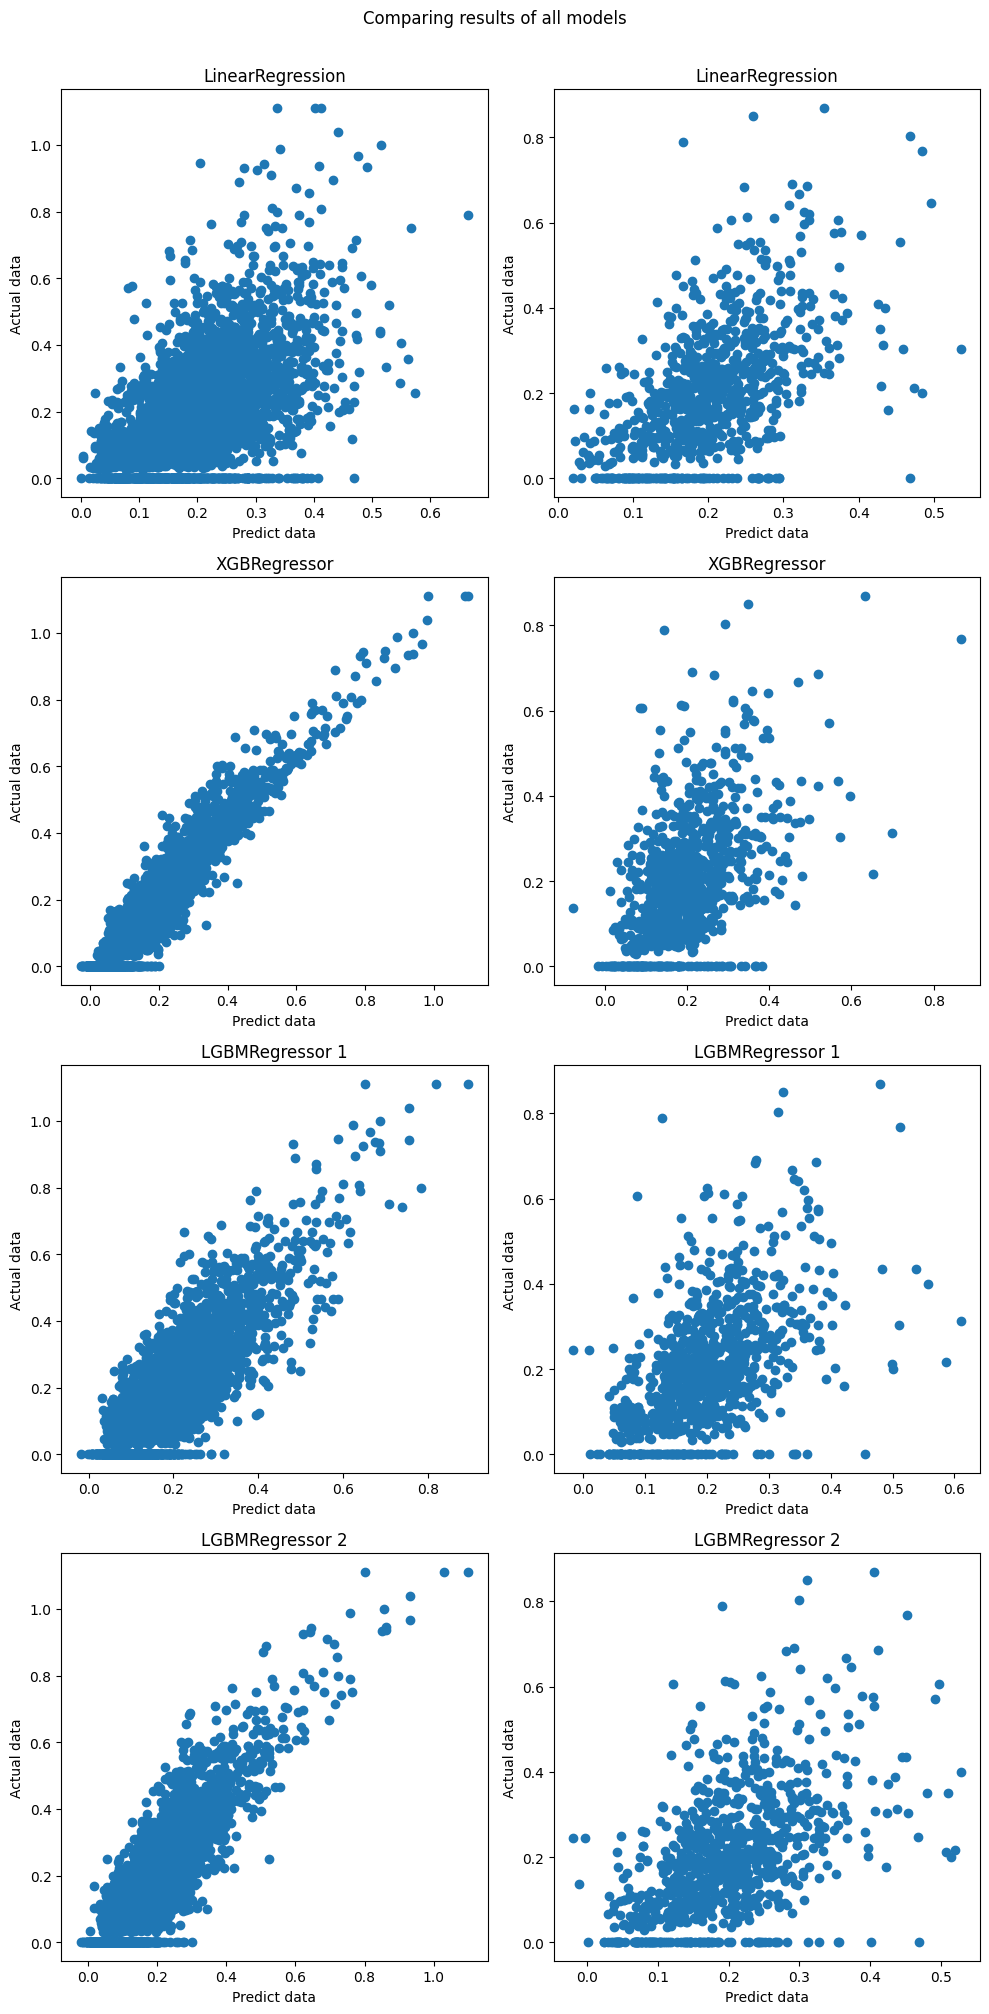

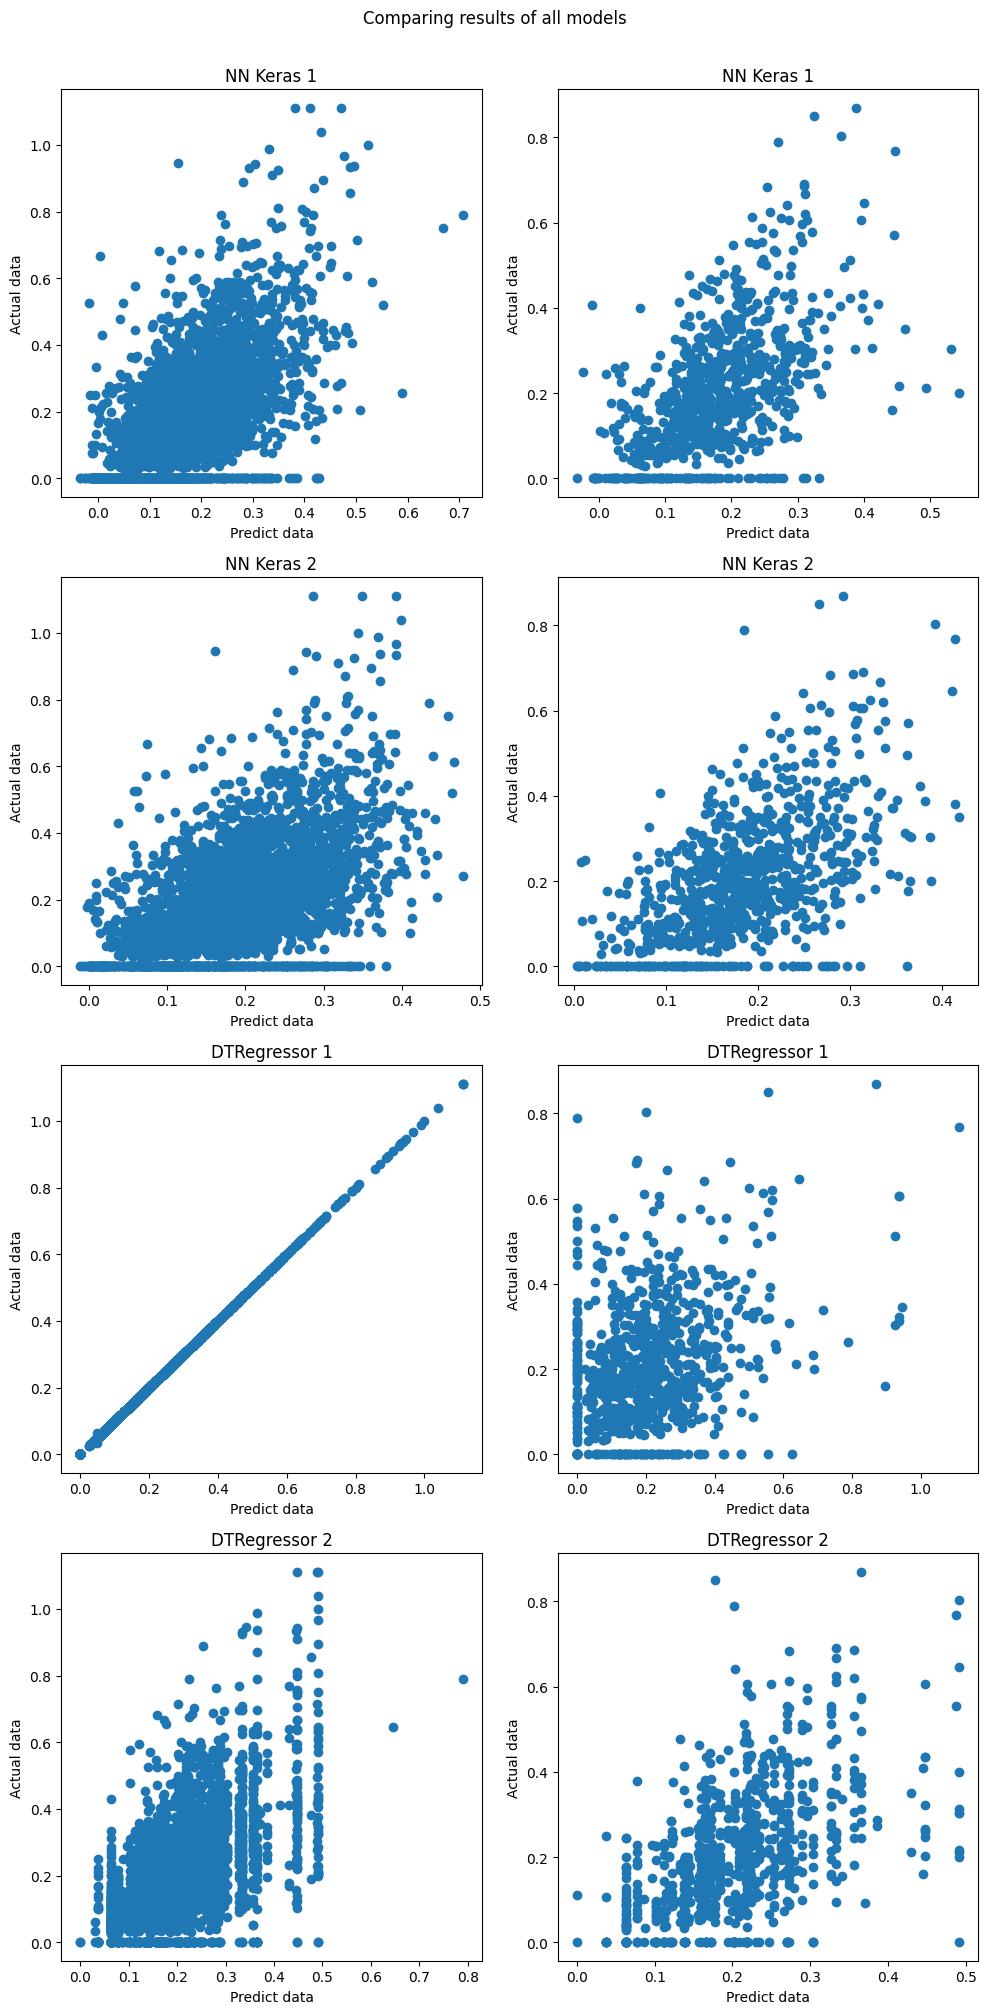

In [1357]:
def generate_diagram_grid(titles, models_short, train_prediction, test_prediction, y_name, suptitle):

    fig, axes = plt.subplots(len(titles), 2, figsize=(10,5 * len(titles)))
    fig.suptitle(suptitle, y=1.005)


    for i, (name, model_short) in enumerate(zip(titles, models_short)):

        axes[i][0].scatter(train_prediction[model_short], train_prediction[y_name])
        axes[i][0].set_title(name, fontsize=12, loc='center')
        axes[i][0].set_xlabel('Predict data', fontsize=10)
        axes[i][0].set_ylabel('Actual data', fontsize=10)

        axes[i][1].scatter(test_prediction[model_short], test_prediction[y_name])
        axes[i][1].set_title(name, fontsize=12, loc='center')
        axes[i][1].set_xlabel('Predict data', fontsize=10)
        axes[i][1].set_ylabel('Actual data', fontsize=10)


    fig.subplots_adjust(hspace=0.5, wspace=0.5) 
    plt.tight_layout() 

    plt.show()

# generate_diagram_grid(models_names, NAMES_OF_PREDICTIONS_COLUMNS, train_predictions_df, test_predictions_df, 'CrdY/90', 'Comparing results of all models')
generate_diagram_grid(models_names[:4], NAMES_OF_PREDICTIONS_COLUMNS[:4], train_predictions_df, test_predictions_df, 'CrdY/90', 'Comparing results of all models')
generate_diagram_grid(models_names[4:], NAMES_OF_PREDICTIONS_COLUMNS[4:], train_predictions_df, test_predictions_df, 'CrdY/90', 'Comparing results of all models')

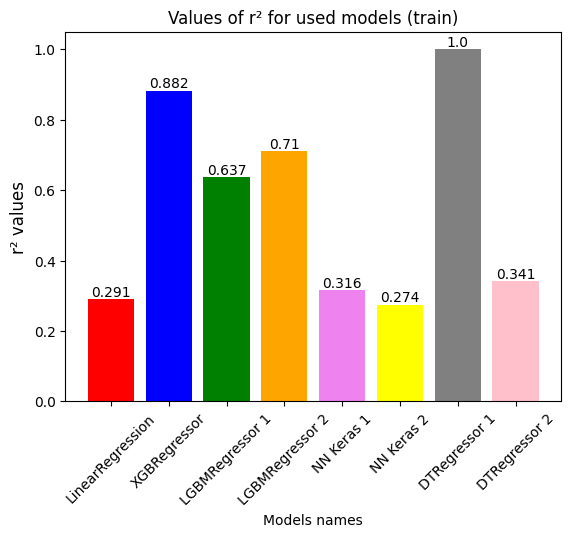

<Figure size 640x480 with 0 Axes>

In [1358]:
def add_values_on_diagram_bars(ax):
    for p in ax.patches:
        wysokość = round(p.get_height(),3)
        ax.annotate(f'{wysokość}', (p.get_x() + p.get_width() / 2, wysokość),
                    ha='center', va='bottom')


def get_all_values(func, columns, y_values, prediction_set):
    result = []
    for column in columns:
        result.append(func(y_values, prediction_set[f'{column}']))
    return result

def get_all_r2_values(columns, y_values, prediction_set):
    return get_all_values(r2_score, columns, y_values, prediction_set)




colors = ['red', 'blue', 'green', 'orange', 'violet', 'yellow', 'grey', 'pink']

train_r2_score_list = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS, y_train, train_predictions_df)

plt.bar(models_names, train_r2_score_list, color=colors)


plt.title('Values of r² for used models (train)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('r² values',  fontsize=12, va='bottom')


add_values_on_diagram_bars(plt.gca())
plt.show()


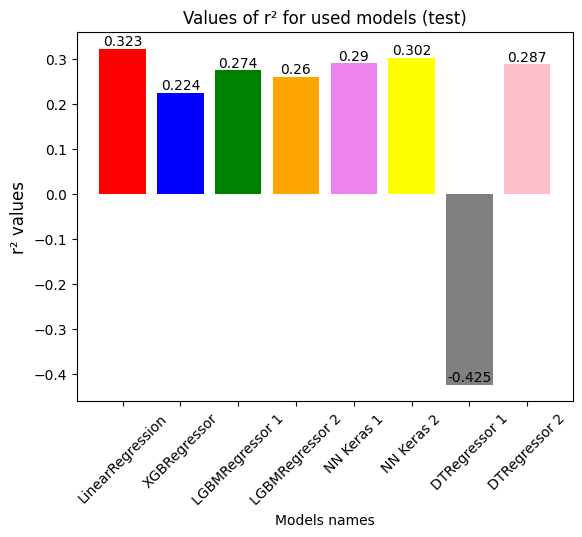

<Figure size 640x480 with 0 Axes>

In [1359]:
test_r2_score_list = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS, y_test, test_predictions_df)

plt.bar(models_names, test_r2_score_list, color=colors)


plt.title('Values of r² for used models (test)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('r² values',  fontsize=12, va='bottom')

add_values_on_diagram_bars(plt.gca())
plt.show()


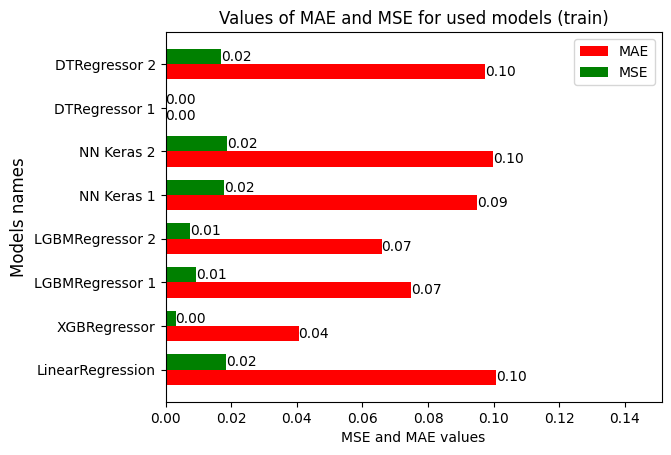

<Figure size 640x480 with 0 Axes>

In [1422]:
def get_all_mse_values(columns, y_values, prediction_set):
    return get_all_values(mean_squared_error, columns, y_values, prediction_set)


def get_all_mae_values(columns, y_values, prediction_set):
    return get_all_values(mean_absolute_error, columns, y_values, prediction_set)

train_mse_score_list = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS, train_predictions_df['CrdY/90'], train_predictions_df)
train_mae_score_list = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS, train_predictions_df['CrdY/90'], train_predictions_df)

def print_mae_mse_comparision(models_names, mse_list, mae_list, title, x_label, y_label='Models names', legend_loc='upper right'):
    indexes = np.arange(len(models_names))

    width = 0.35

    fig, ax = plt.subplots()
    bars1 = ax.barh(indexes, mae_list, height=width, color='red', label='MAE')
    bars2 = ax.barh(indexes + width, mse_list, height=width, color='green', label='MSE')

    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label, fontsize=12, va='bottom')
    plt.xlim(0, 1.5*max(mse_list + mae_list))
    plt.legend(loc=legend_loc)

    for bar1, bar2 in zip(bars1, bars2):
        width1 = bar1.get_width()
        width2 = bar2.get_width()
        ax.text(width1, bar1.get_y() + bar1.get_height() / 2, '%.2f' % width1, ha='left', va='center')
        ax.text(width2, bar2.get_y() + bar2.get_height() / 2, '%.2f' % width2, ha='left', va='center')

    plt.yticks(indexes + width/2, models_names)

    plt.show()

print_mae_mse_comparision(models_names, train_mse_score_list, train_mae_score_list, 'Values of MAE and MSE for used models (train)', 'MSE and MAE values')



So let's now calculate the mean value of number of yellow cards per 90 minutes scored by all players for the training data

In [1423]:
median_crdY_90 = train_predictions_df['CrdY/90'].median()
median_crdY_90

0.18518518518518517

Now, for each model, let's calculate what fraction of the average number of yellow cards per 90 minutes is due to their MAE and MSE errors.

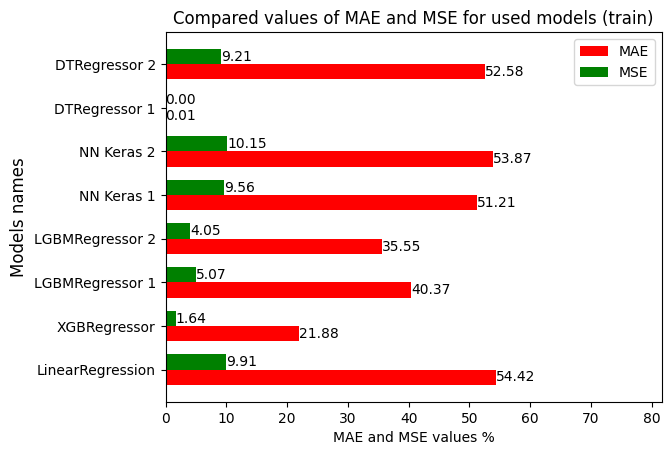

<Figure size 640x480 with 0 Axes>

In [1424]:
compared_to_prediction_mae_train = [error/median_crdY_90 * 100 for error in train_mae_score_list]

compared_to_prediction_mse_train = [error/median_crdY_90 * 100 for error in train_mse_score_list]

print_mae_mse_comparision(models_names, compared_to_prediction_mse_train, compared_to_prediction_mae_train, 'Compared values of MAE and MSE for used models (train)', 'MAE and MSE values %')

In our case, the `MAE` will be a better indicator, because it indicates the real difference between the prediction and our data.

Unfortunately, for the training data alone, the smallest difference of 20% is quite a significant departure from reality and gives us reliable results.

Let's check how this situation looks for test data.

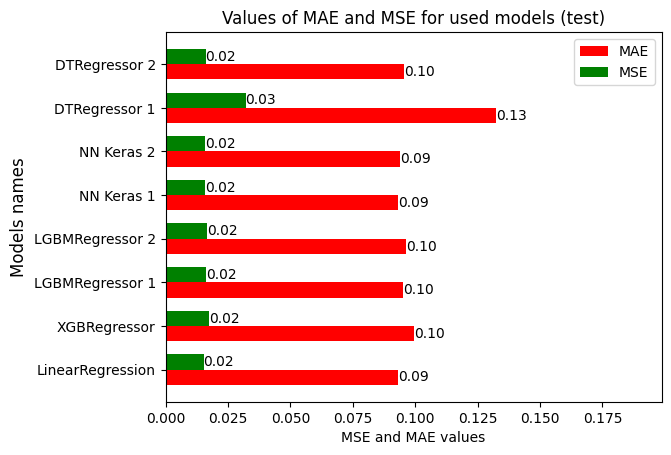

<Figure size 640x480 with 0 Axes>

In [1439]:
test_mse_score_list = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS, test_predictions_df['CrdY/90'], test_predictions_df)
test_mae_score_list = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS, test_predictions_df['CrdY/90'], test_predictions_df)

print_mae_mse_comparision(models_names, test_mse_score_list, test_mae_score_list , 'Values of MAE and MSE for used models (test)', 'MSE and MAE values')

So let's now calculate the mean value of number of yellow cards per 90 minutes scored by all players for the test data

In [1427]:
median_crdY_90 = test_predictions_df['CrdY/90'].median()
median_crdY_90

0.18404907975460122

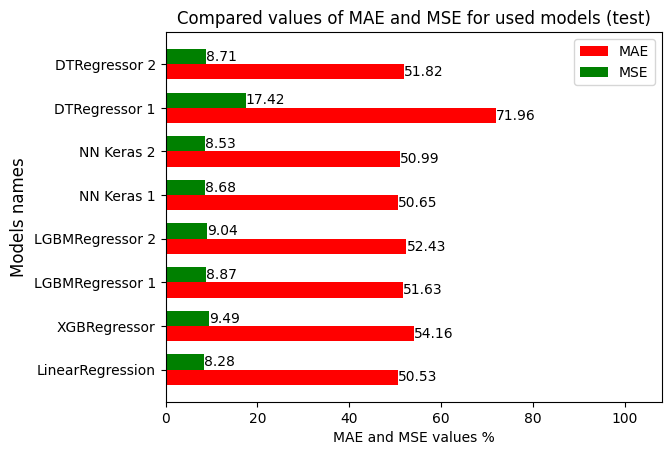

<Figure size 640x480 with 0 Axes>

In [1438]:

compared_to_prediction_mae_test = [error/median_crdY_90 * 100 for error in test_mae_score_list]

compared_to_prediction_mse_test = [error/median_crdY_90  * 100 for error in test_mse_score_list]

print_mae_mse_comparision(models_names, compared_to_prediction_mse_test, compared_to_prediction_mae_test , 'Compared values of MAE and MSE for used models (test)', 'MAE and MSE values %')

Here the situation, as I expected, is even worse. The smallest `MAE` error is roughly half of the average number of yellow cards per player per 90 minutes.

Let's try to change tactics and predict the number of yellow cards throughout the season.


In [1366]:
train_predictions_df.to_csv('./checkpoints/train_prediction_df.csv')
test_predictions_df.to_csv('./checkpoints/test_prediction_df.csv')

We will use the following stats as our new traits:
+ Pos - player's position
+ Min - minutes played
+ Fls - number of fouls committed
+ Fld - number of fouls drawn
+ Int - number of interceptions (the catching of a pass by a player on an opposing team)
+ TklW - number of tackles in which the tackler's team won possession of the ball
+ Recov - number of loose balls recovered

We will use the same models in exactly the same way, and by comparing the results, we will be able to answer the question of whether our main hypothesis is correct.

Below, a LinearRegression object was created and our data was trained on it.

In [1367]:
lr = LinearRegression()

X_train, y_train = players[['Pos','Min' ,'Fls', 'Fld', 'Int', 'TklW', 'Recov']], players[['CrdY']]

X_test, y_test = test_players[['Pos', 'Min', 'Fls' ,'Fld', 'Int', 'TklW', 'Recov']], test_players[['CrdY']]


model11 = lr.fit(X_train, y_train)

print(f'coef = {model11.coef_}')
print(f'intercept = {model11.intercept_}')

coef = [[-0.13721626  0.00021294  0.11574336  0.00635061  0.03066969 -0.00127684
   0.00028151]]
intercept = [0.6805319]


Let's update our testing data with other stats as well and make a prediction for our testing data.

Now it's time for another model we already know - `XGBRegressor`

In [1368]:
xgbr = XGBRegressor()

model22 = xgbr.fit(X_train, y_train)

For the `LGBMRegressor` model, the calculations were made again in two ways - without and with parameters.

In [1369]:
lgbm = LGBMRegressor()
model33 = lgbm.fit(X_train, y_train)

This time we will apply the same parameters to the `LGBMRegressor` model as before

In [1370]:
lgbm = LGBMRegressor(objective='regression', 
                    n_estimators=750, 
                    max_depth=4, 
                    learning_rate=0.05, 
                    min_child_samples=1,
                    colsample_bytree=0.9,
                    subsample=0.9,
                    random_state=101)

model44 = lgbm.fit(X_train, y_train)

Now it's the turn of neural networks and, like the previous models, they will be launched with the same parameters.

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


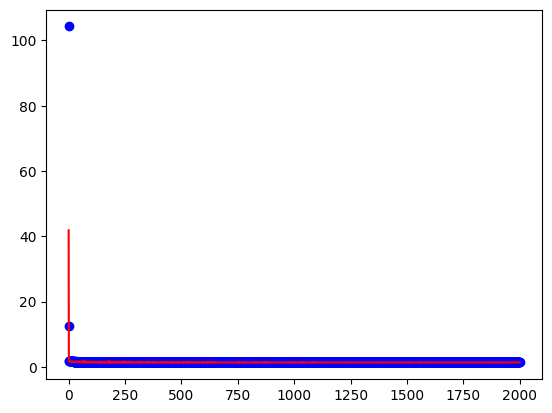

In [1371]:

model55 = make_neural_network(X_train, y_train, X_test, y_test)

As it was before, the graph above shows the error rate of the model when moving through successive epochs.

c:\Users\trine\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 200: early stopping


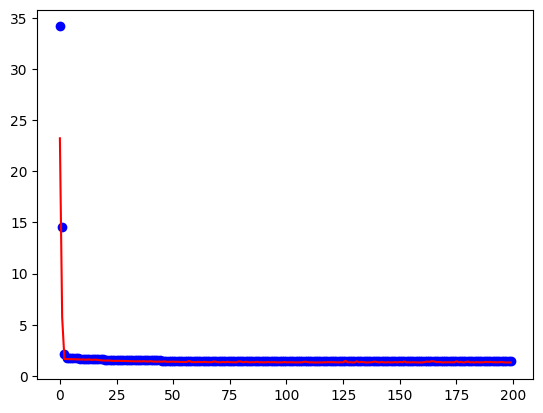

In [1372]:
model66 = make_neural_network(X_train, y_train, X_test, y_test, earlystopper)

The diagram above shows how the error of our model decreased over the epochs.

Now let's move on to the last model - `DecisionTreeRegressor`

In [1373]:
dtr1 = DecisionTreeRegressor()
model77 = dtr1.fit(X_train, y_train)

As a reminder, I present the parameters that will be selected for our `DecisionTreeRegressor` model:

In [1374]:
# param_grid = {
#     'criterion': ['absolute_error', 'squared_error', 'friedman_mse'],
#     'splitter' : ['random', 'best'],
#     'max_depth' : [70, 80, 90, 100],
#     'min_samples_split' : [50, 55, 60, 65, 70, 75],
#     'min_impurity_decrease' : [0.0025, 0.005, 0.01]
# }

gridSearch = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
gridSearch.fit(X_train, y_train)
print('The best score: ', gridSearch.best_score_)
print('The best parameters: ', gridSearch.best_params_)

The best score:  -3.742105114054614
The best parameters:  {'criterion': 'squared_error', 'max_depth': 80, 'min_impurity_decrease': 0.005, 'min_samples_split': 60, 'splitter': 'random'}


Now let's train the model for the best parameters on our training data.

In [1375]:
dtr2 = DecisionTreeRegressor(**gridSearch.best_params_)
model88 = dtr2.fit(X_train, y_train)

Let's create more `DataFrames` containing the data needed for prediction. These sets will be passed to a function that will generate the predicted number of yellow cards.

In [1376]:
train_predictions_df_1 = pd.DataFrame({
    'Player': players['Player'],
    'Pos': players['Pos'],
    'Min': players['Min'],
    'Fls': players['Fls'],
    'Fld': players['Fld'],
    'Int': players['Int'],
    'TklW': players['TklW'],
    'Recov': players["Recov"],
    'CrdY': players['CrdY'],
})

test_predictions_df_1 = pd.DataFrame({
    'Player': test_players['Player'],
    'Pos': test_players['Pos'],
    'Min': test_players['Min'],
    'Fls': test_players['Fls'],
    'Fld': test_players['Fld'],
    'Int': test_players['Int'],
    'TklW': test_players['TklW'],
    'Recov': test_players["Recov"],
    'CrdY': test_players['CrdY']
})

Let us now summarize the results of our models

In [1377]:
NAMES_OF_PREDICTIONS_COLUMNS_1 = [column_name[:-3] for column_name in NAMES_OF_PREDICTIONS_COLUMNS]


models_2 = [model11, model22, model33, model44, model55, model66, model77, model88]


train_predictions_df_1, test_predictions_df_1= predict_and_print_statistics(models_2, models_names, NAMES_OF_PREDICTIONS_COLUMNS_1, X_train,y_train, X_test, y_test, train_predictions_df_1, test_predictions_df_1)


------------------------
Statistics for LinearRegression
Train r²: 0.5476446686249803
Train MAE: 1.4217204682277602
Train MSE: 3.5468046029407985
Test r²: 0.556120576993897
Test MAE: 1.3301030418412774
Test MSE: 3.170867586165118
------------------------
Statistics for XGBRegressor
Train r²: 0.9380073904218715
Train MAE: 0.5140088740325989
Train MSE: 0.4860684902986866
Test r²: 0.47385898789172964
Test MAE: 1.447456168477028
Test MSE: 3.75850601442114
------------------------
Statistics for LGBMRegressor 1
Train r²: 0.7835015105579289
Train MAE: 1.0210278877248018
Train MSE: 1.697510310199633
Test r²: 0.5076758924097875
Test MAE: 1.401205758423135
Test MSE: 3.51693381971439
------------------------
Statistics for LGBMRegressor 2
Train r²: 0.8217995492872137
Train MAE: 0.9099486570693515
Train MSE: 1.3972250021084613
Test r²: 0.5002197905447878
Test MAE: 1.4072756449171355
Test MSE: 3.5701967341400214
------------------------
Statistics for NN Keras 1
108/108 [==========================

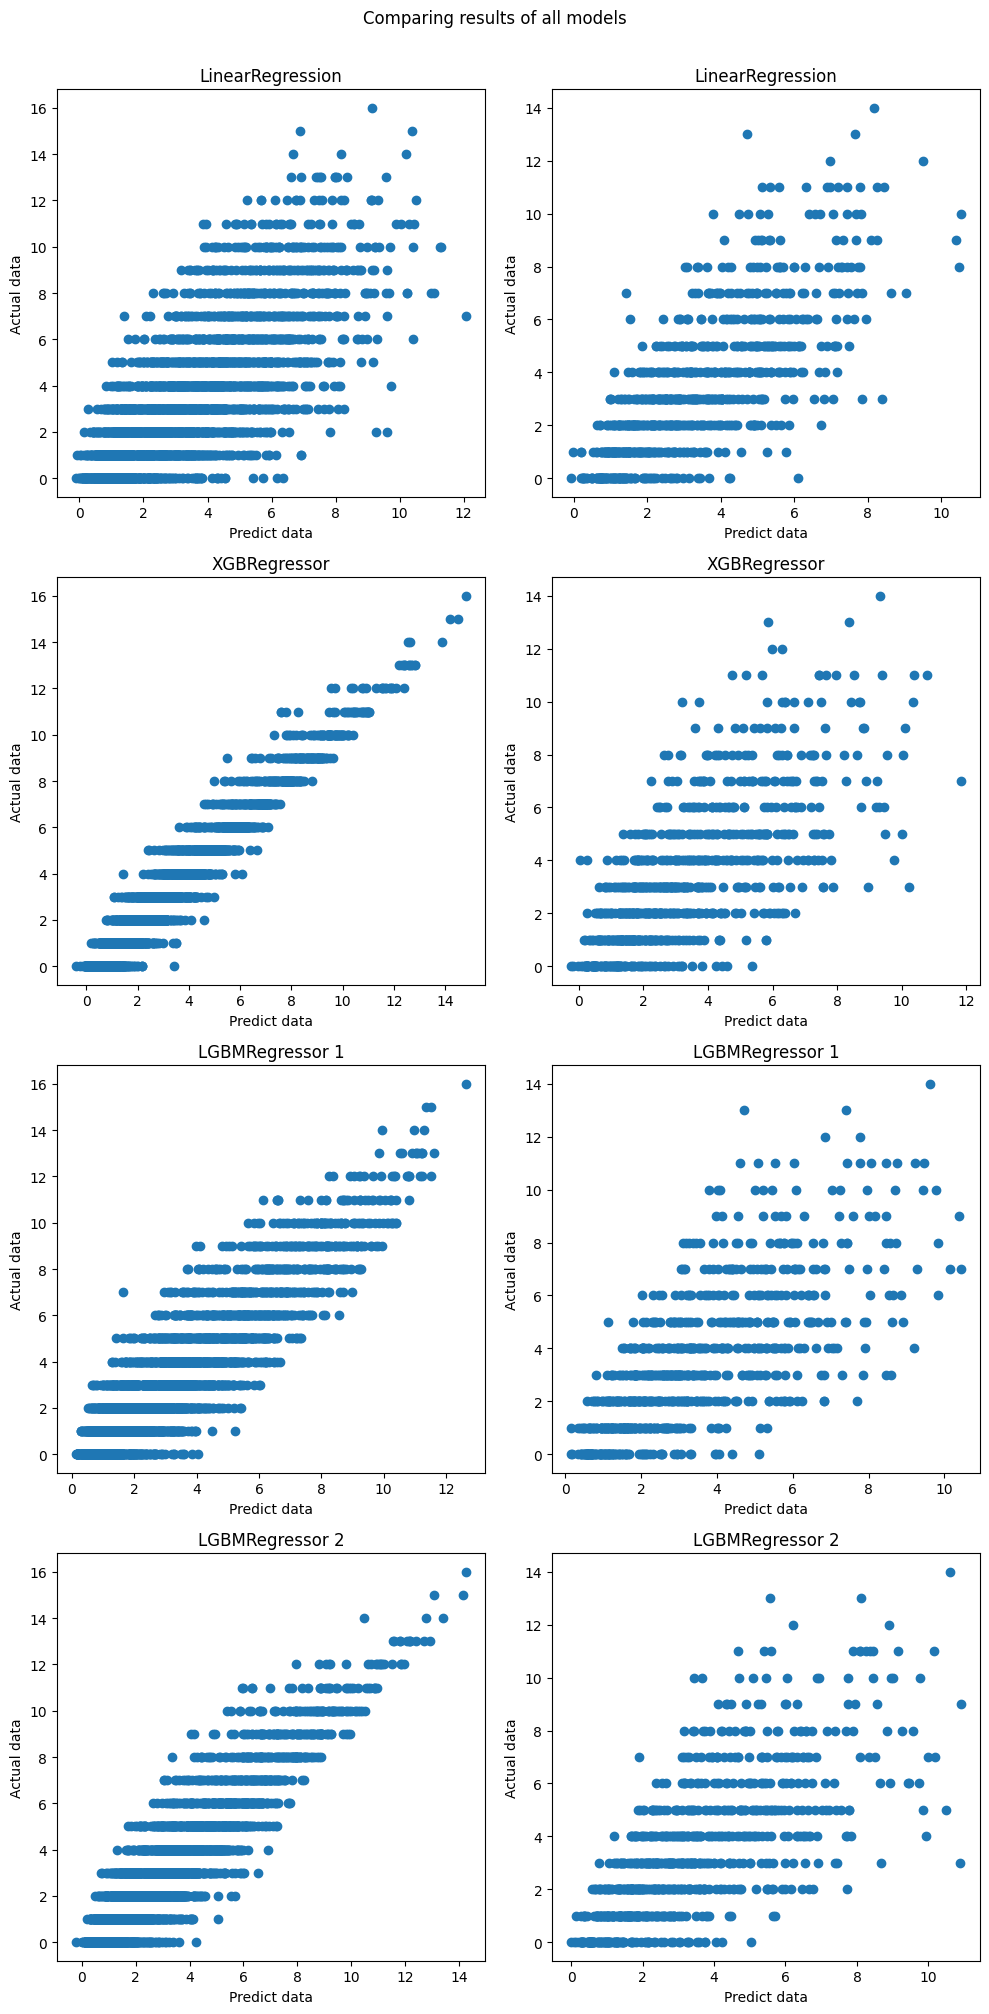

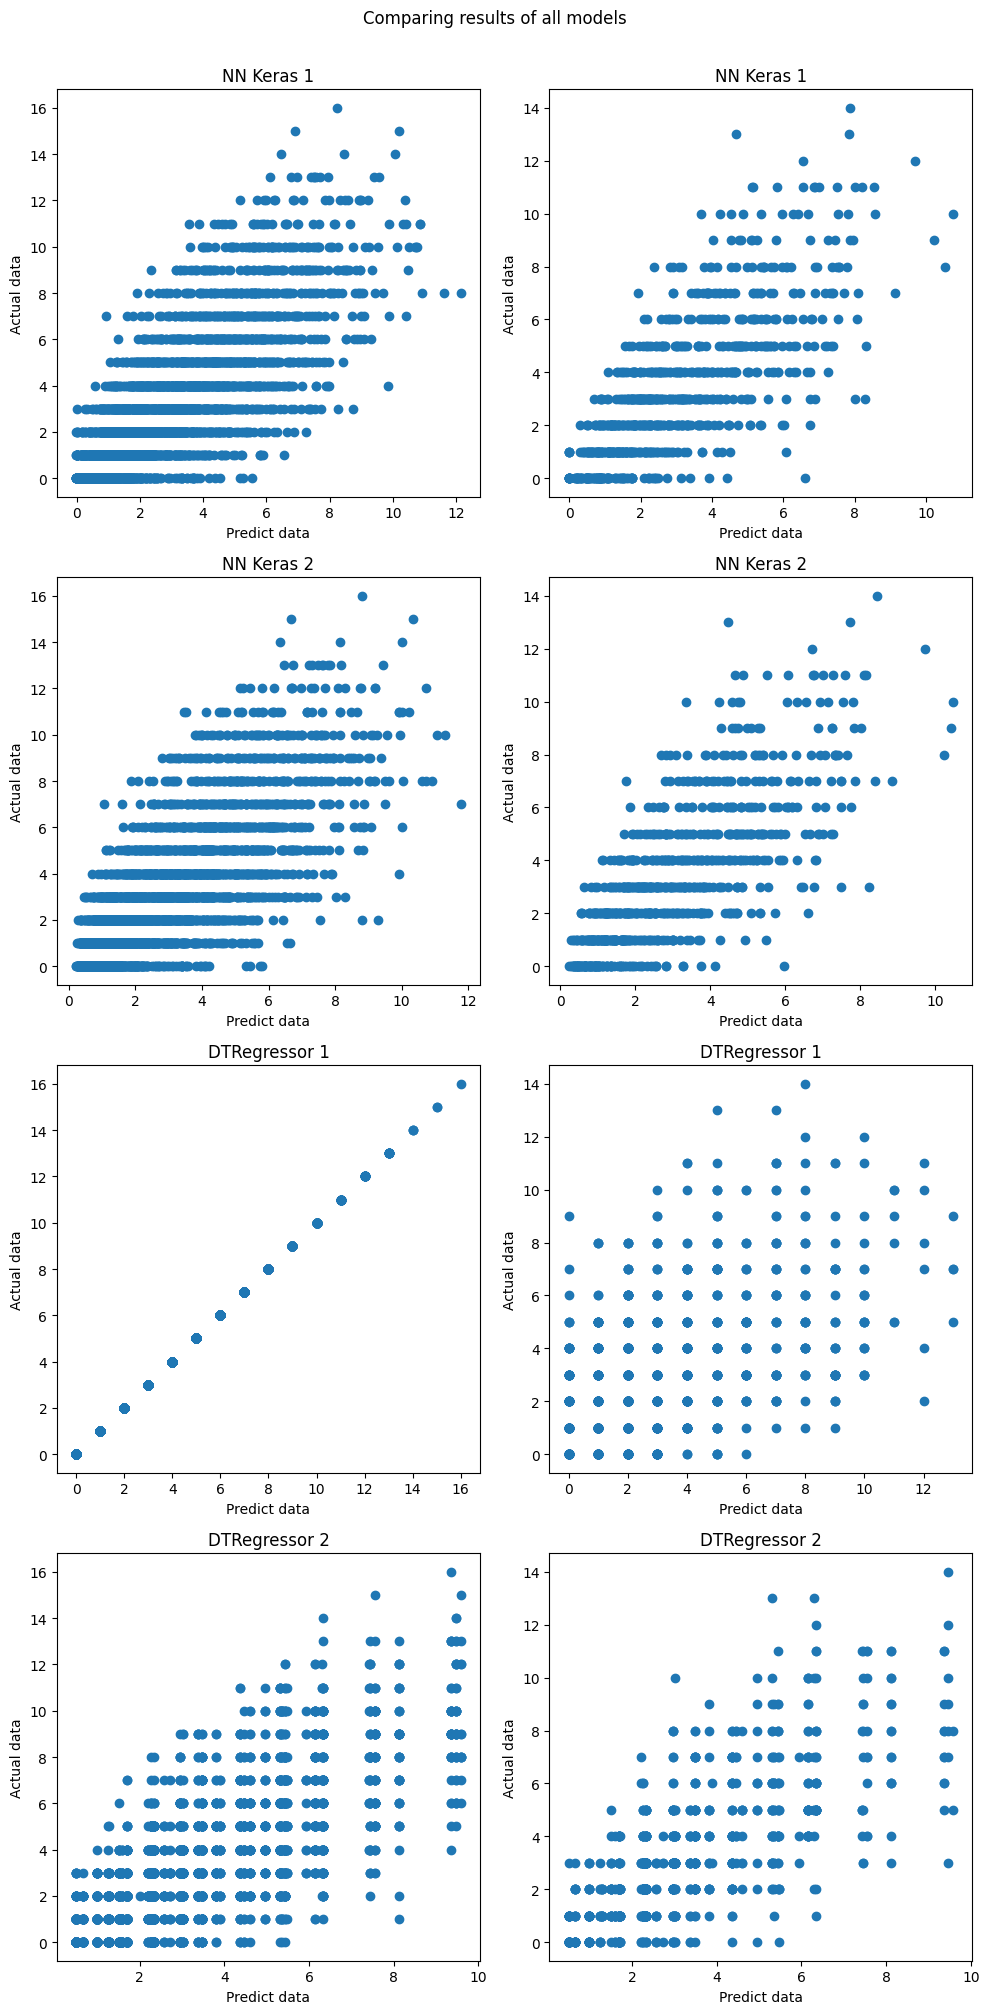

In [1378]:
generate_diagram_grid(models_names[:4], NAMES_OF_PREDICTIONS_COLUMNS_1[:4], train_predictions_df_1, test_predictions_df_1, 'CrdY', 'Comparing results of all models')
generate_diagram_grid(models_names[4:], NAMES_OF_PREDICTIONS_COLUMNS_1[4:], train_predictions_df_1, test_predictions_df_1, 'CrdY', 'Comparing results of all models')

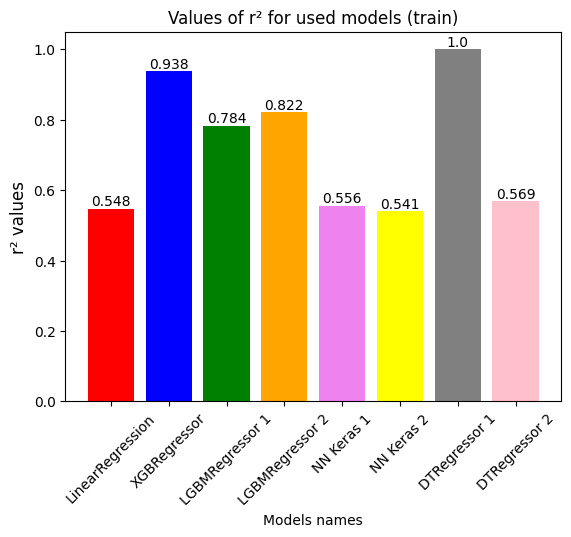

<Figure size 640x480 with 0 Axes>

In [1389]:
train_r2_score_list_1 = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_train, train_predictions_df_1)

plt.bar(models_names, train_r2_score_list_1, color=colors)

plt.title('Values of r² for used models (train)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('r² values',  fontsize=12, va='bottom')


add_values_on_diagram_bars(plt.gca())
plt.show()

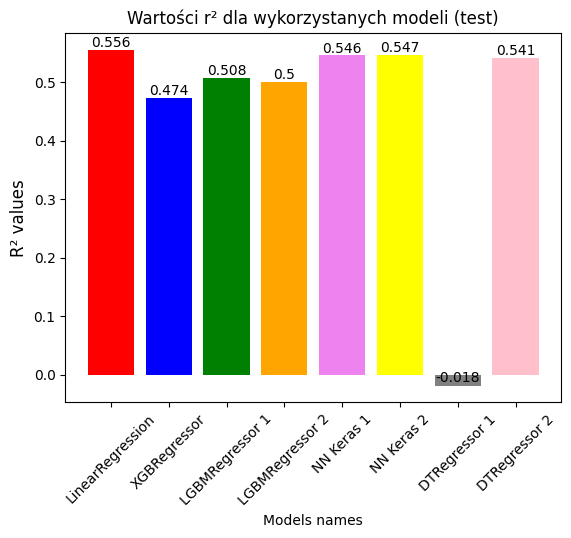

<Figure size 640x480 with 0 Axes>

In [1380]:
test_r2_score_list_1 = get_all_r2_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_test, test_predictions_df_1)

plt.bar(models_names, test_r2_score_list_1, color=colors)


plt.title('Wartości r² dla wykorzystanych modeli (test)')
plt.xticks(rotation=45)
plt.xlabel('Models names')
plt.ylabel('R² values',  fontsize=12, va='bottom')

add_values_on_diagram_bars(plt.gca())
plt.show()

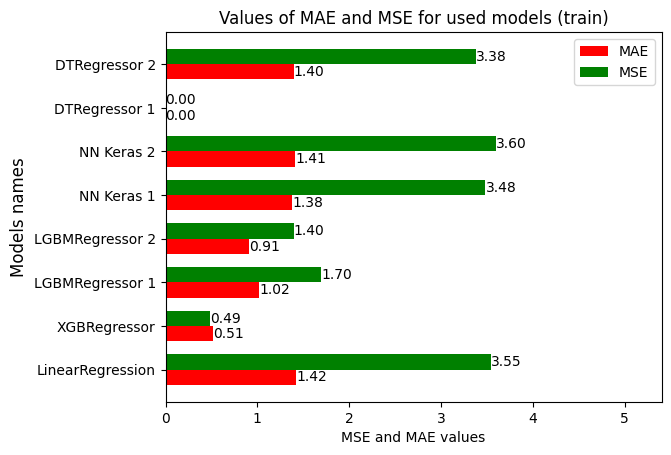

<Figure size 640x480 with 0 Axes>

In [1429]:
train_mse_score_list_1 = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS_1, train_predictions_df_1['CrdY'], train_predictions_df_1)
train_mae_score_list_1 = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS_1, train_predictions_df_1['CrdY'], train_predictions_df_1)

print_mae_mse_comparision(models_names, train_mse_score_list_1, train_mae_score_list_1, 'Values of MAE and MSE for used models (train)', 'MSE and MAE values')

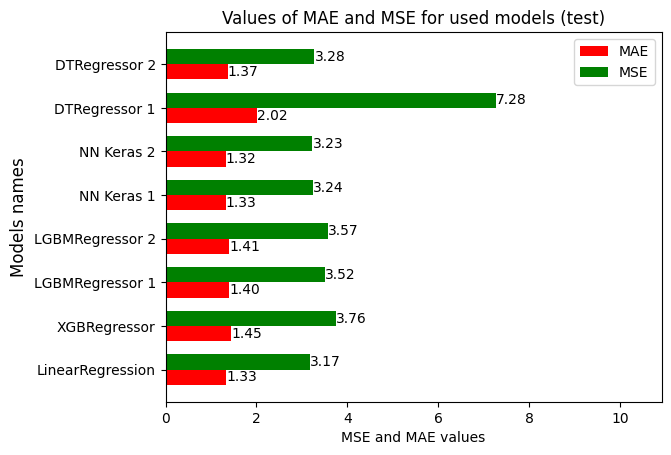

<Figure size 640x480 with 0 Axes>

In [1437]:
test_mse_score_list_1 = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS_1, test_predictions_df_1['CrdY'], test_predictions_df_1)
test_mae_score_list_1 = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS_1, test_predictions_df_1['CrdY'], test_predictions_df_1)


print_mae_mse_comparision(models_names, test_mse_score_list_1, test_mae_score_list_1 , 'Values of MAE and MSE for used models (test)', 'MSE and MAE values')


Now let's calculate the median value for the number of yellow cards scored by all players for the training data

In [1431]:
median_crdY = train_predictions_df_1['CrdY'].median()
median_crdY

3.0

Now, for each model, let's calculate what fraction of the average number of yellow cards  is due to their MAE and MSE errors.

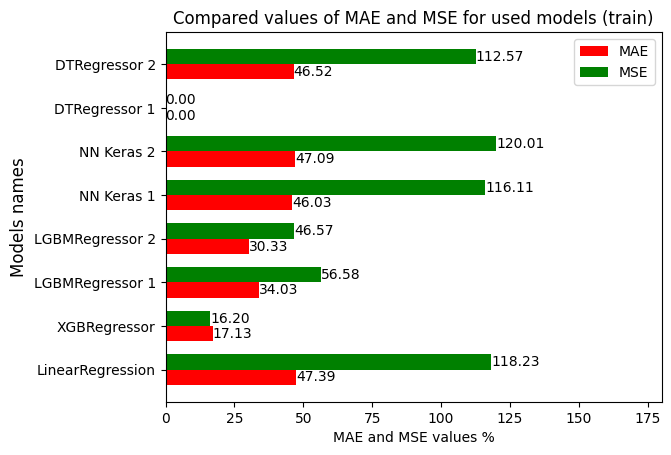

<Figure size 640x480 with 0 Axes>

In [1434]:
compared_to_prediction_mae_train_1 = [error/median_crdY * 100 for error in train_mae_score_list_1]

compared_to_prediction_mse_train_1 = [error/median_crdY  * 100 for error in train_mse_score_list_1]


print_mae_mse_comparision(models_names, compared_to_prediction_mse_train_1, compared_to_prediction_mae_train_1 , 'Compared values of MAE and MSE for used models (train)', 'MAE and MSE values %')

Also in this case, the `MSE` does not give adequate information about the fit of our model. So let's see what the situation looks like for the `MAE` itself.

For the training data alone, the smallest error is 0% for the first `DecisionTreeRegressor` model, but the others give errors of 15% to almost 44% of the average yellow cards scored per season, which does not speak well of the quality of our models and their predictions.

Let's check what the situation looks like for our test data, because this will be the most important criterion for choosing the best model and confirming or rejecting our main hypothesis.

In [1435]:
median_crdY = test_predictions_df_1['CrdY'].median()
median_crdY

3.0

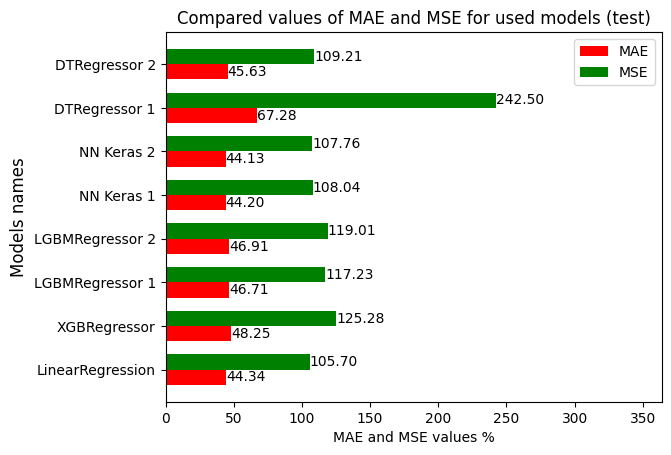

<Figure size 640x480 with 0 Axes>

In [1436]:

compared_to_prediction_mae_test_1 = [error/median_crdY * 100 for error in test_mae_score_list_1]

compared_to_prediction_mse_test_1 = [error/median_crdY  * 100 for error in test_mse_score_list_1]


print_mae_mse_comparision(models_names, compared_to_prediction_mse_test_1, compared_to_prediction_mae_test_1 , 'Compared values of MAE and MSE for used models (test)', 'MAE and MSE values %')

As the graph above shows us, the best model for the training data - first `DecisionTreeRegressor` model - turned out to be the worst for the test data. This is probably due to excessive overtraining of the model and too much adjustment to the training data.

The other models keep the error at 40% of the average number of yellow cards and ultimately gives us the answer that the yellow card data is quite unpredictable and difficult to predict based on player statistics.

In [1386]:
train_predictions_df_1.to_csv('./checkpoints/train_prediction_df_1.csv')
test_predictions_df_1.to_csv('./checkpoints/test_prediction_df_1.csv')



Below are graphs showing statistics for the rounded results of our models for total yellow cards.

In [1402]:
rounded_train_predictions_df_1 = pd.DataFrame()
rounded_test_predictions_df_1 = pd.DataFrame()


for name in NAMES_OF_PREDICTIONS_COLUMNS_1:
    rounded_train_predictions_df_1[name] = train_predictions_df_1[name].round(0)
    rounded_test_predictions_df_1[name] = test_predictions_df_1[name].round(0)


,CrdY
0,0.0
1,0.0
2,4.0
3,4.0
4,0.0
...,...
3420,2.0
3421,2.0
3422,3.0
3423,2.0


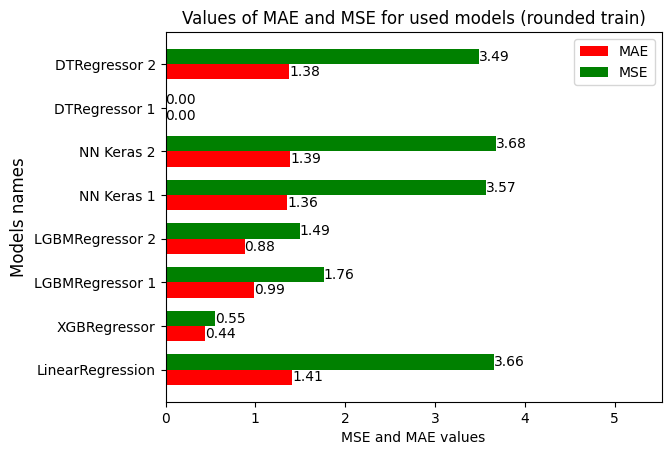

In [1441]:
rounded_train_mse_score_list_1 = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_train, rounded_train_predictions_df_1)
rounded_train_mae_score_list_1 = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_train, rounded_train_predictions_df_1)

print_mae_mse_comparision(models_names, rounded_train_mse_score_list_1, rounded_train_mae_score_list_1, 'Values of MAE and MSE for used models (rounded train)', 'MSE and MAE values')

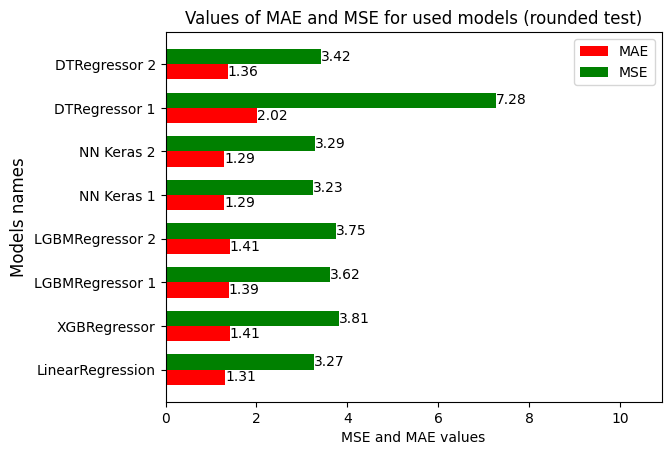

In [1443]:
rounded_test_mse_score_list_1 = get_all_mse_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_test, rounded_test_predictions_df_1)
rounded_test_mae_score_list_1 = get_all_mae_values(NAMES_OF_PREDICTIONS_COLUMNS_1, y_test, rounded_test_predictions_df_1)

print_mae_mse_comparision(models_names, rounded_test_mse_score_list_1, rounded_test_mae_score_list_1, 'Values of MAE and MSE for used models (rounded test)', 'MSE and MAE values')

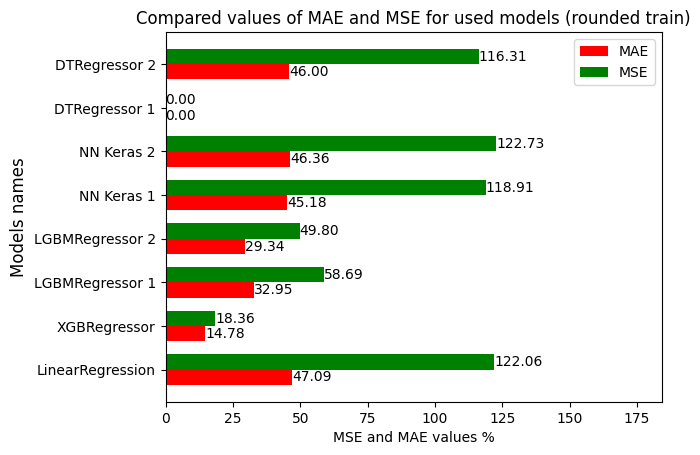

In [1444]:
compared_to_rounded_prediction_mae_train_1 = [error/median_crdY * 100 for error in rounded_train_mae_score_list_1]

compared_to_rounded_prediction_mse_train_1 = [error/median_crdY  * 100 for error in rounded_train_mse_score_list_1]


print_mae_mse_comparision(models_names, compared_to_rounded_prediction_mse_train_1, compared_to_rounded_prediction_mae_train_1 , 'Compared values of MAE and MSE for used models (rounded train)', 'MSE and MAE values %')

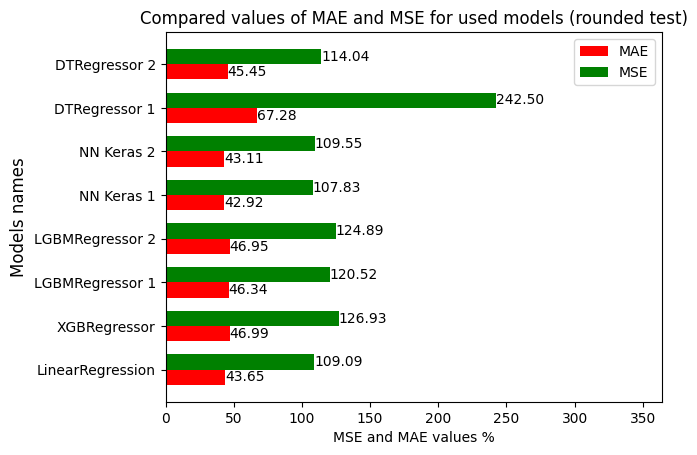

In [1445]:
compared_to_rounded_prediction_mae_test_1 = [error/median_crdY * 100 for error in rounded_test_mae_score_list_1]

compared_to_rounded_prediction_mse_test_1 = [error/median_crdY  * 100 for error in rounded_test_mse_score_list_1]


print_mae_mse_comparision(models_names, compared_to_rounded_prediction_mse_test_1, compared_to_rounded_prediction_mae_test_1 , 'Compared values of MAE and MSE for used models (rounded test)', 'MSE and MAE values %')